In [199]:
pip install pandasql

In [200]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [201]:
#from sklearn.datasets import make_classification

import pandas as pd
from pandas import set_option
import time
import numpy as np
from numpy import mean
from numpy import std
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt # plotting library for Python
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

import pyodbc
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

import warnings
warnings.filterwarnings('ignore')
import scipy as sp

from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score,  GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_predict 
from sklearn.utils.class_weight import compute_class_weight
from sklearn.datasets import make_classification
from collections import Counter

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedBaggingClassifier 
from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, roc_curve, auc
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier

In [202]:
#Load data
df = pd.read_csv('diabetic_data.csv')
pd.options.display.max_columns = 50
print('There are ', len(df), ' instances in the dataset and ', (len(df.columns)) , 'attributes.', '\n')
display(df.head())

There are  101766  instances in the dataset and  50 attributes. 



encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital payer_code         medical_specialty  num_lab_procedures  \
0                 1          ?  Pediatrics-Endocrinology                  41   
1                 3          ?                         ?                  59   
2                 2          ?                         ?                  11   
3                 2          ?                         ?                  44   
4                 1          ?                         ?                  51   

   num_procedures  num_medications  number_outpatient  number_emergency  \
0               0                1                  0                 0   
1               0               18                  0                 0   
2               5               13                  2                 0   
3               1               16                  0                 0   
4               0                8                  0                 0   

   number_inpatient  diag_1  diag_2 diag_3  number_diagnoses max_glu_serum  \
0                 0  250.83       ?      ?                 1           NaN   
1                 0     276  250.01    255                 9           NaN   
2                 1     648     250    V27                 6           NaN   
3                 0       8  250.43    403                 7           NaN   
4                 0     197     157    250                 5           NaN   

  A1Cresult metformin repaglinide nateglinide chlorpropamide glimepiride  \
0       NaN        No          No          No             No          No   
1       NaN        No          No          No             No          No   
2       NaN        No          No          No             No          No   
3       NaN        No          No          No             No          No   
4       NaN        No          No          No             No          No   

  acetohexamide glipizide glyburide tolbutamide pioglitazone rosiglitazone  \
0            No        No        No          No           No            No   
1            No        No        No          No           No            No   
2            No    Steady        No          No           No            No   
3            No        No        No          No           No            No   
4            No    Steady        No          No           No            No   

  acarbose miglitol troglitazone tolazamide examide citoglipton insulin  \
0       No       No           No         No      No          No      No   
1       No       No           No         No      No          No      Up   
2       No       No           No         No      No          No      No   
3       No       No           No         No      No          No      Up   
4       No       No           No         No      No          No  Steady   

  glyburide-metformin glipizide-metformin glimepiride-pioglitazone  \
0                  No                  No                       No   
1                  No                  No                       No   
2                  No                  No                       No   
3                  No                  No                       No   
4        

In [203]:
#Load mapping document

mp = pd.read_csv('Readmission_IDs_mapping.csv')
pd.options.display.max_rows = 80
print('The mapping document has codes & descriptions for ',mp.Variable.unique())
mp.head(80)

The mapping document has codes & descriptions for  ['admission_type' 'discharge_disposition' 'admission_source']


Variable  Id  \
0          admission_type   1   
1          admission_type   2   
2          admission_type   3   
3          admission_type   4   
4          admission_type   5   
5          admission_type   6   
6          admission_type   7   
7          admission_type   8   
8   discharge_disposition   1   
9   discharge_disposition   2   
10  discharge_disposition   3   
11  discharge_disposition   4   
12  discharge_disposition   5   
13  discharge_disposition   6   
14  discharge_disposition   7   
15  discharge_disposition   8   
16  discharge_disposition   9   
17  discharge_disposition  10   
18  discharge_disposition  11   
19  discharge_disposition  12   
20  discharge_disposition  13   
21  discharge_disposition  14   
22  discharge_disposition  15   
23  discharge_disposition  16   
24  discharge_disposition  17   
25  discharge_disposition  18   
26  discharge_disposition  19   
27  discharge_disposition  20   
28  discharge_disposition  21   
29  discharge_disposition  22   
30  discharge_disposition  23   
31  discharge_disposition  24   
32  discharge_disposition  25   
33  discharge_disposition  26   
34  discharge_disposition  30   
35  discharge_disposition  27   
36  discharge_disposition  28   
37  discharge_disposition  29   
38       admission_source   1   
39       admission_source   2   
40       admission_source   3   
41       admission_source   4   
42       admission_source   5   
43       admission_source   6   
44       admission_source   7   
45       admission_source   8   
46       admission_source   9   
47       admission_source  10   
48       admission_source  11   
49       admission_source  12   
50       admission_source  13   
51       admission_source  14   
52       admission_source  15   
53       admission_source  17   
54       admission_source  18   
55       admission_source  19   
56       admission_source  20   
57       admission_source  21   
58       admission_source  22   
59       admission_source  23   
60       admission_source  24   
61       admission_source  25   
62       admission_source  26   

                                          description  
0                                           Emergency  
1                                              Urgent  
2                                            Elective  
3                                             Newborn  
4                                       Not Available  
5                                                 NaN  
6                                       Trauma Center  
7                                          Not Mapped  
8                                  Discharged to home  
9   Discharged/transferred to another short term h...  
10                      Discharged/transferred to SNF  
11                      Discharged/transferred to ICF  
12  Discharged/transferred to another type of inpa...  
13  Discharged/transferred to home with home healt...  
14                                           Left AMA  
15  Discharged/transferred to home under care of H...  
16          Admitted as an inpatient to this hospital  
17  Neonate discharged to another hospital for neo...  
18                                            Expired  
19  Still patient or expected to return for outpat...  
20                                     Hospice / home  
21                         Hospice / medical facility  
22  Discharged/transferred within this institution...  
23  Discharged/transferred/referred another instit...  
24  Discharged/transferred/referred to this instit...  
25                                                NaN  
26           Expired at home. Medicaid only, hospice.  
27  Expired in a medical facility. Medicaid only, ...  
28    Expired, place unknown. Medicaid only, hospice.  
29  Discharged/transferred to another rehab fac in...  
30  Discharged/transferred to a long term care hos...  
31  Discharged/transferred to a nursing facility c...  
32                                         Not Mapped  


In [204]:
#View the summary of the df columns, data types, and non-null values
set_option('display.max_rows', 50) 

display(df.info())                      # check for total records,  nulls, and data types of each attribute

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

None

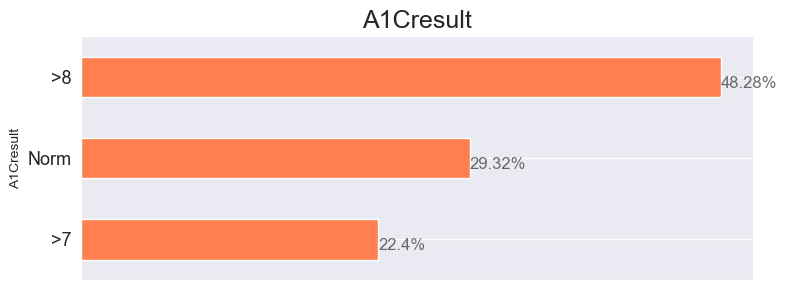

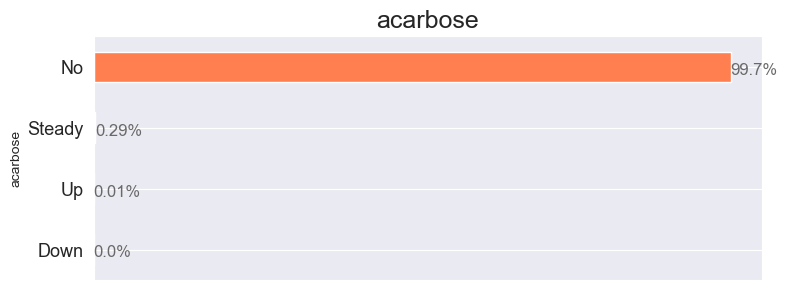

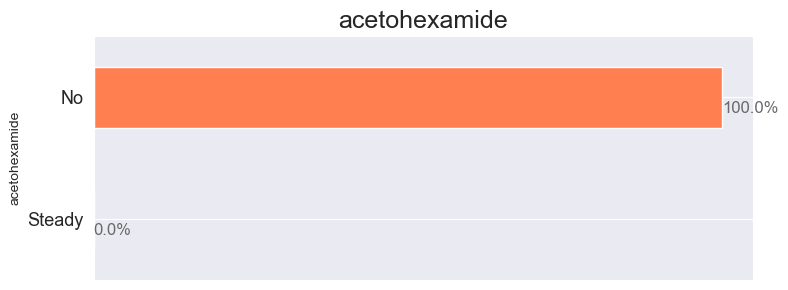

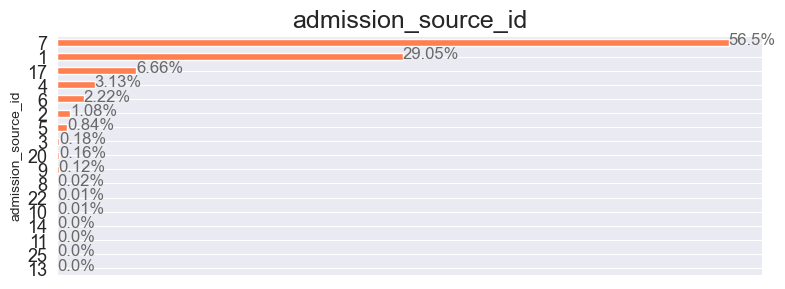

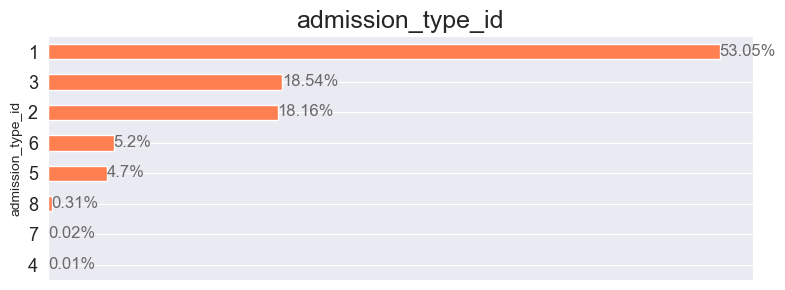

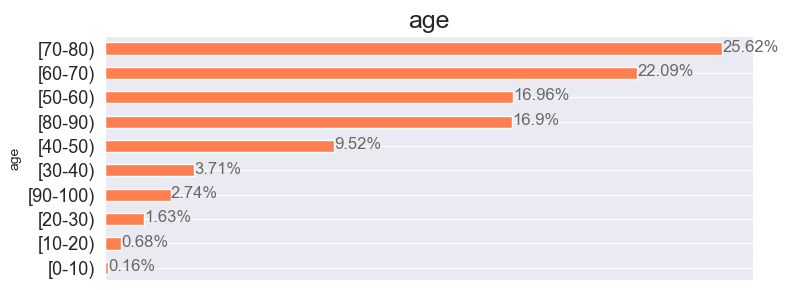

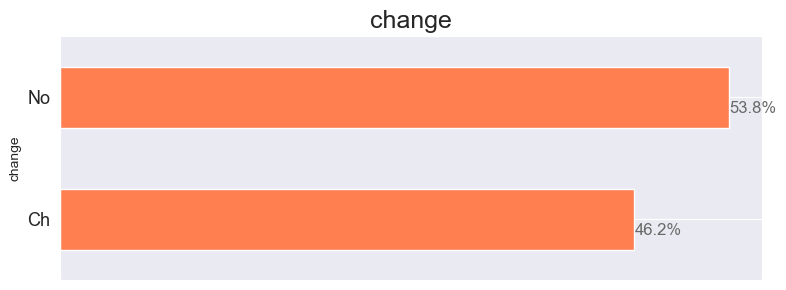

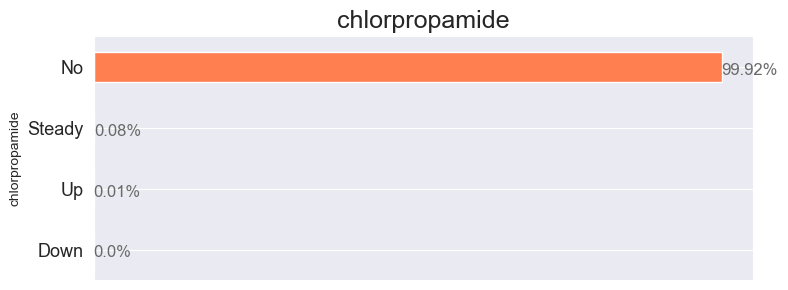

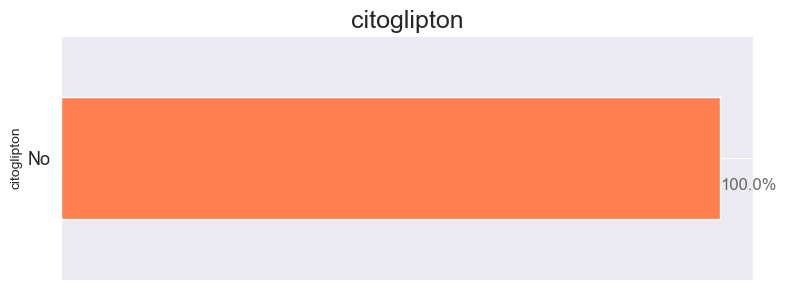

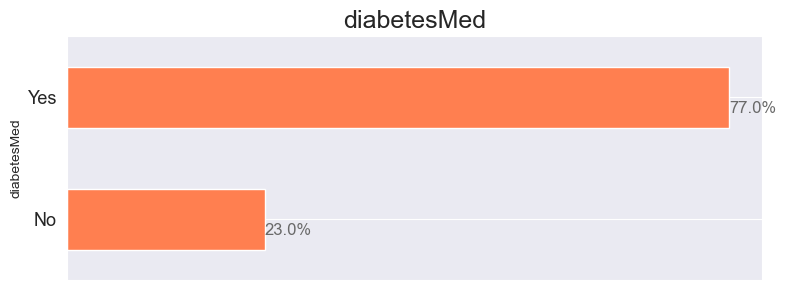

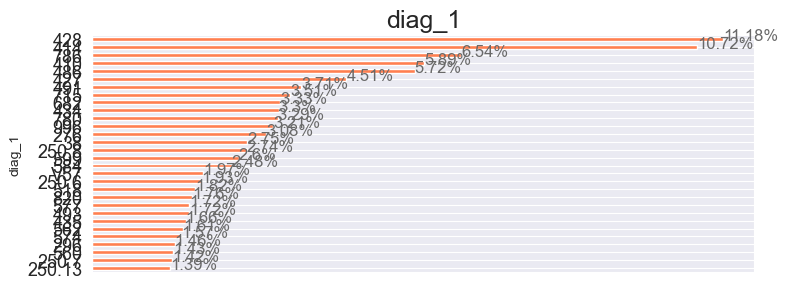

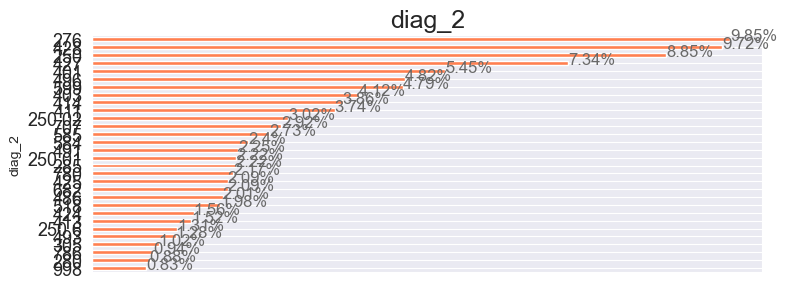

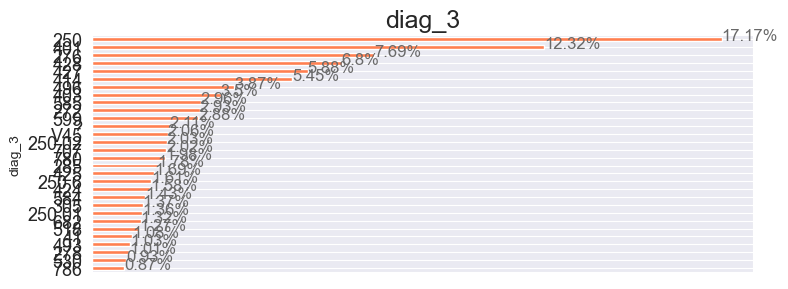

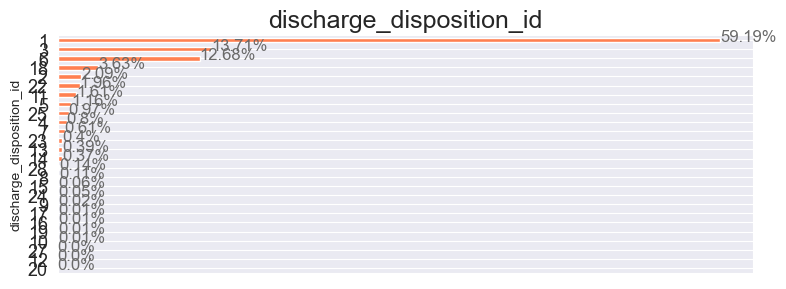

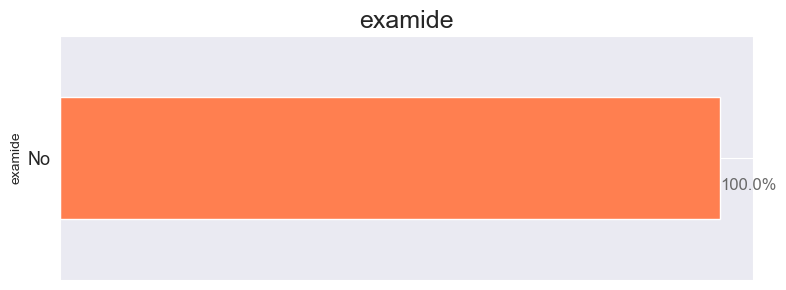

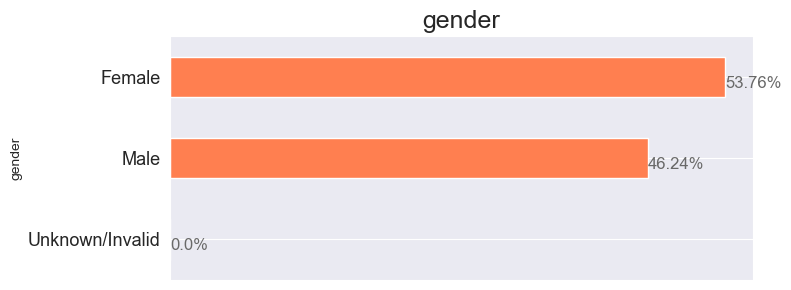

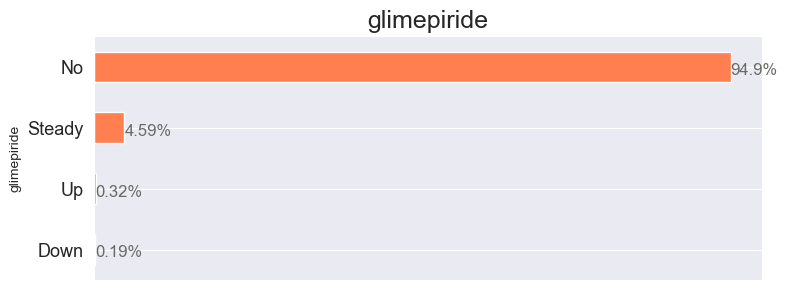

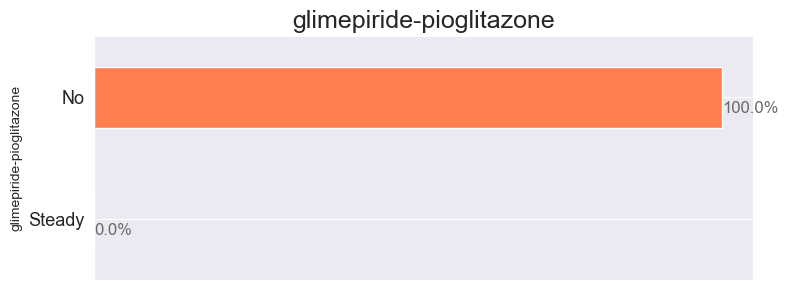

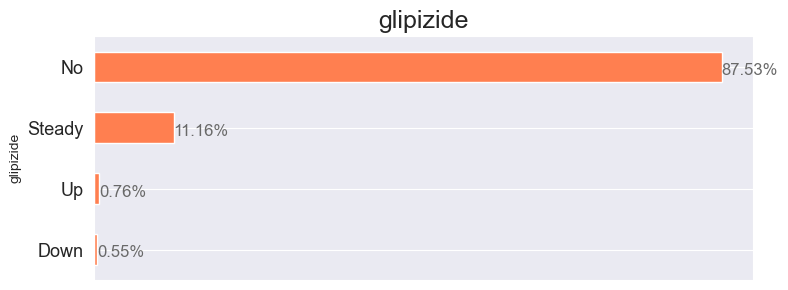

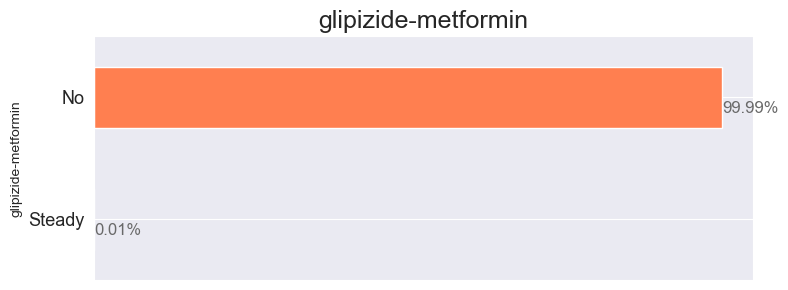

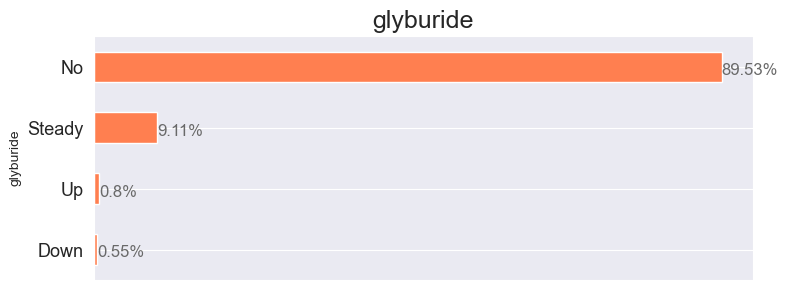

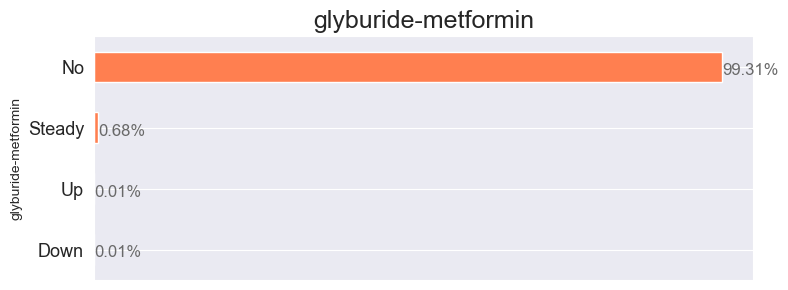

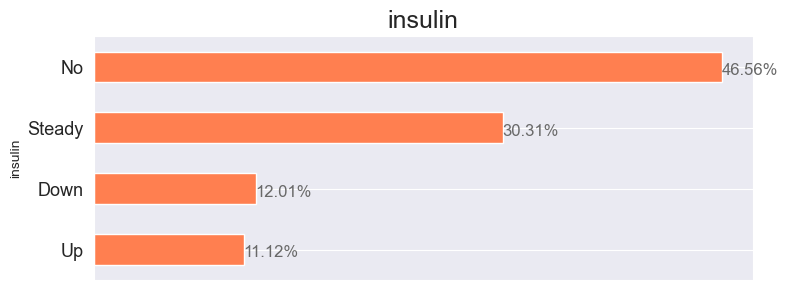

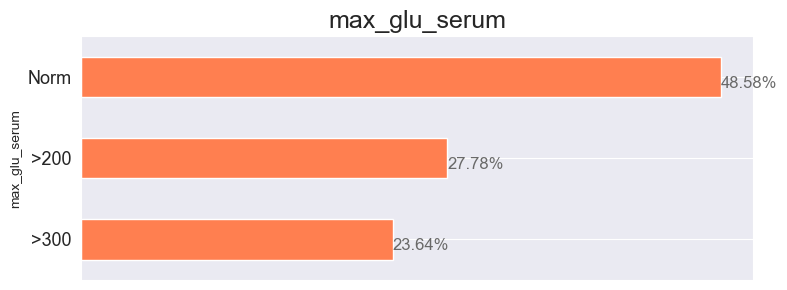

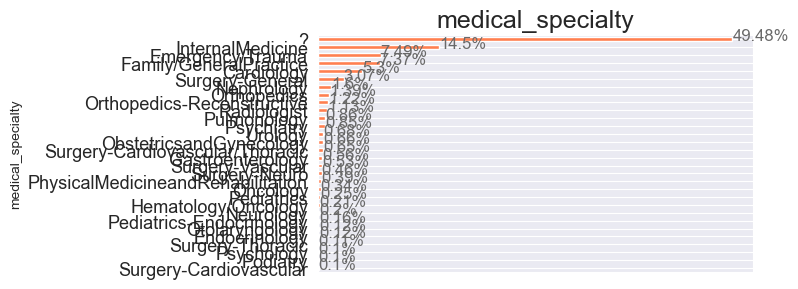

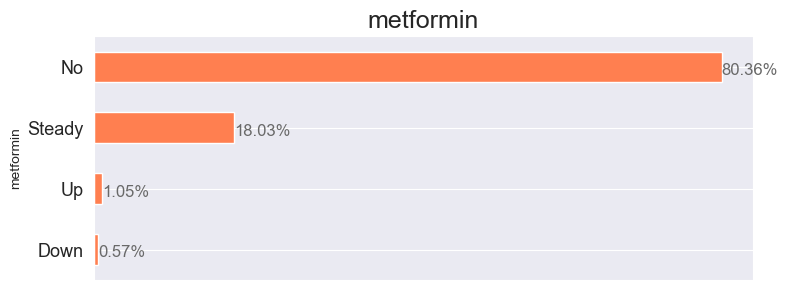

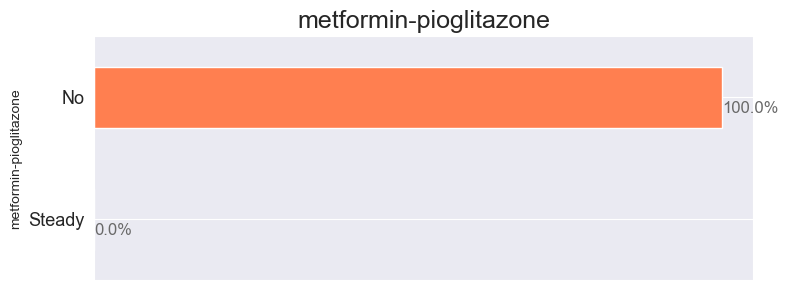

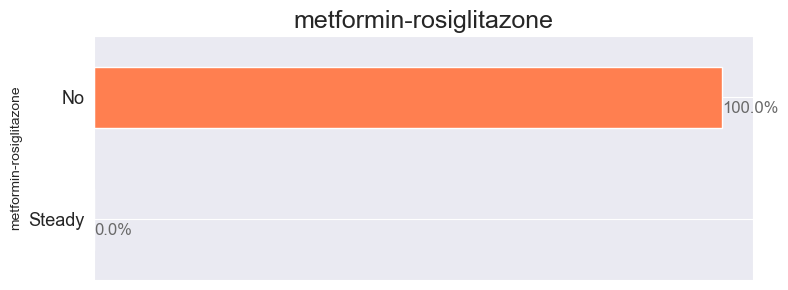

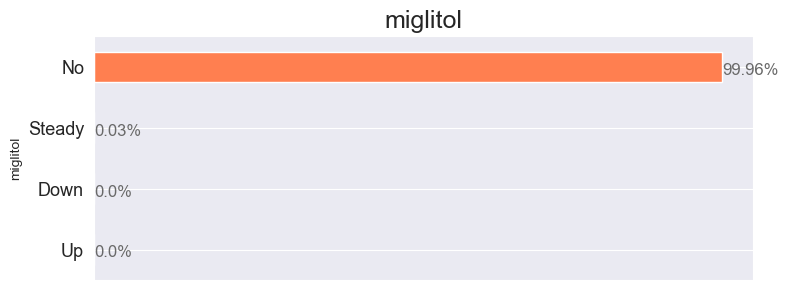

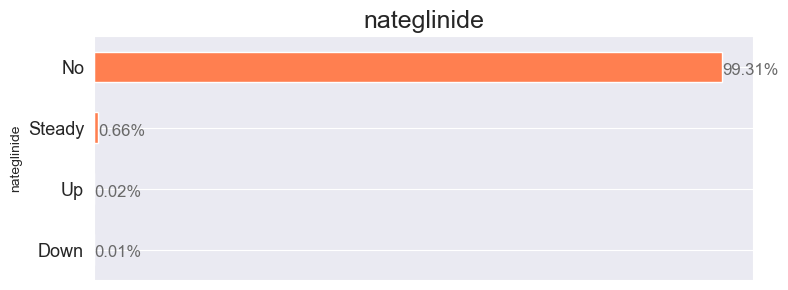

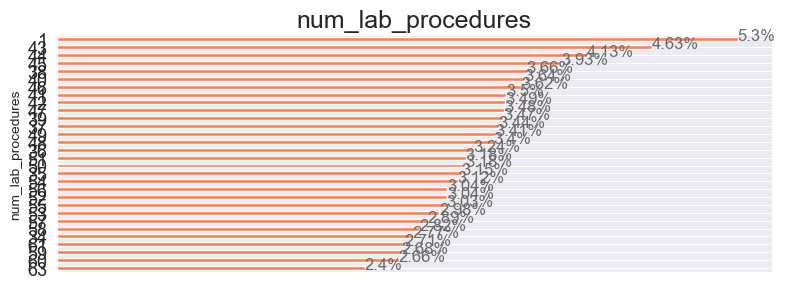

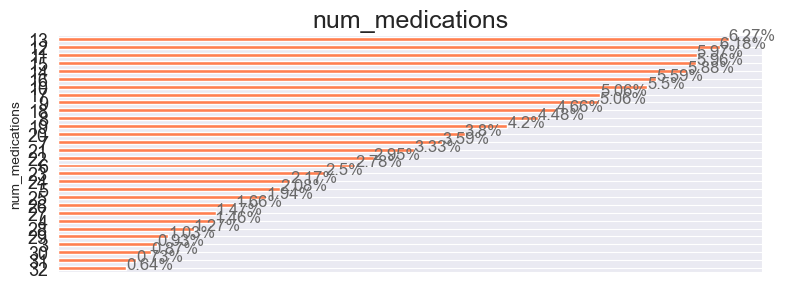

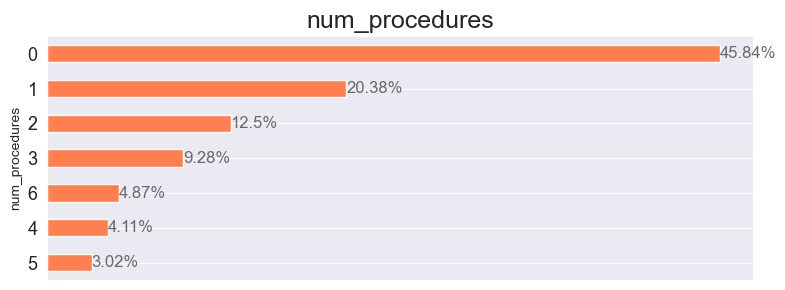

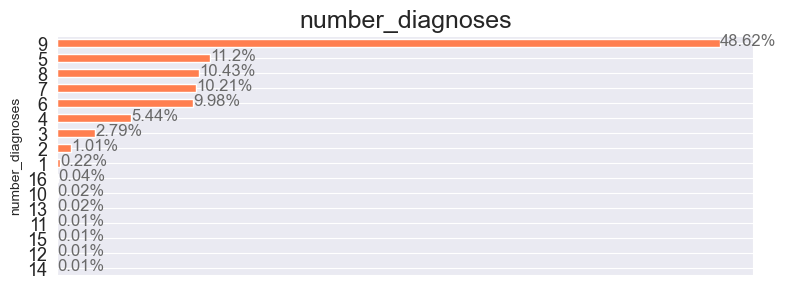

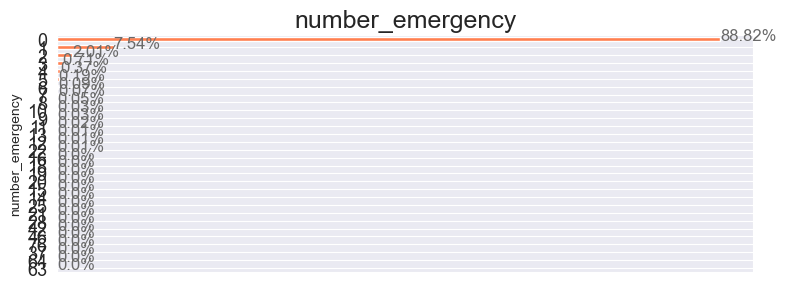

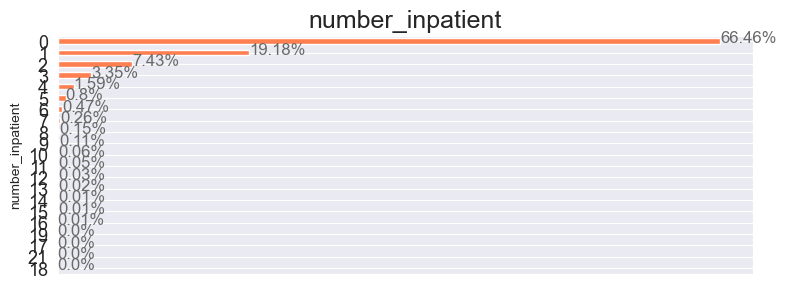

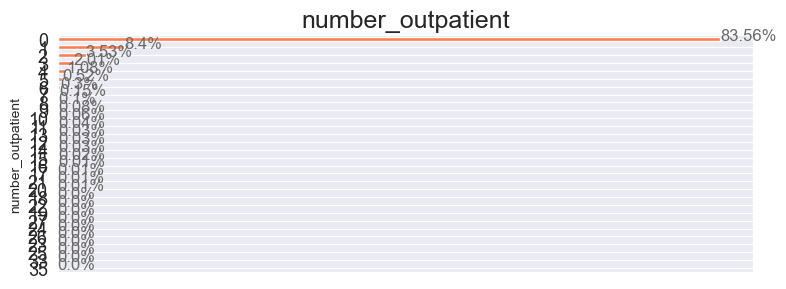

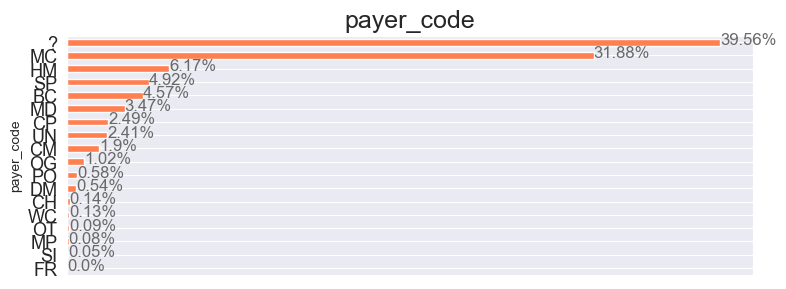

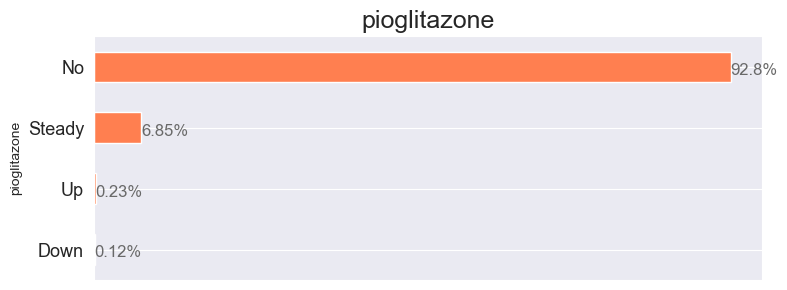

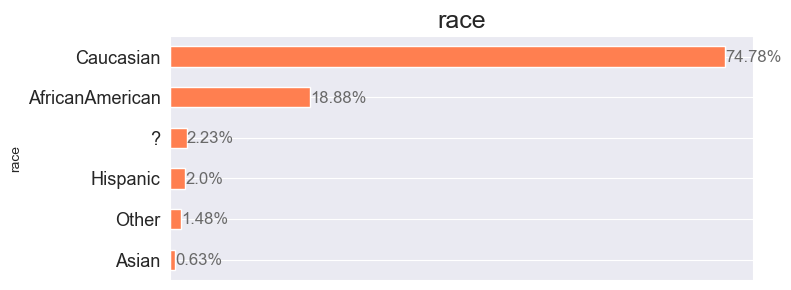

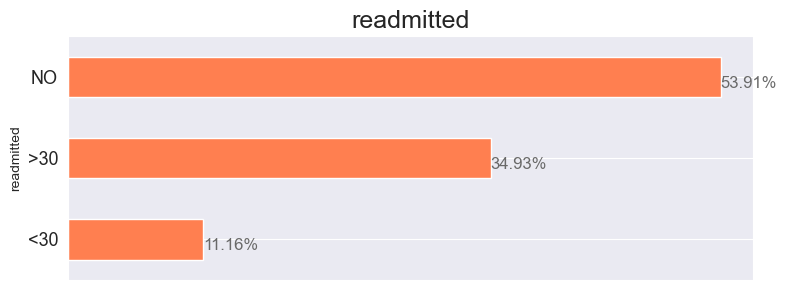

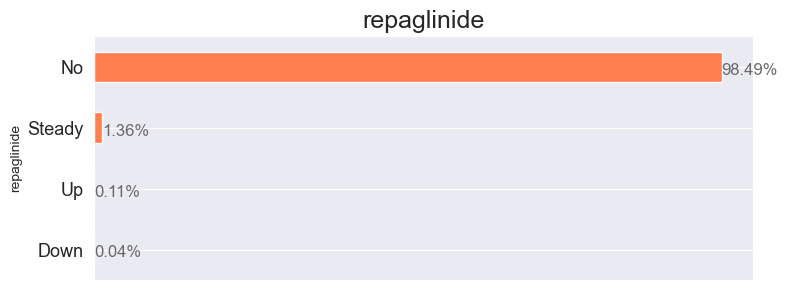

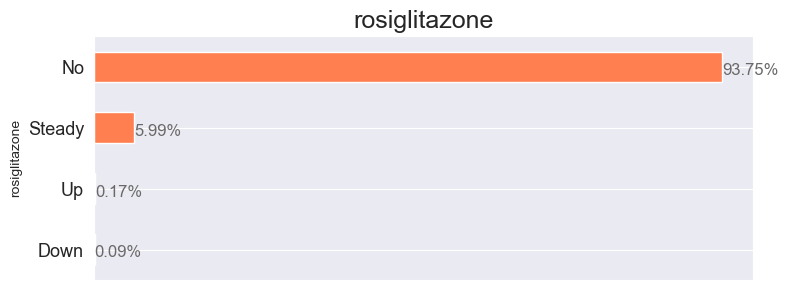

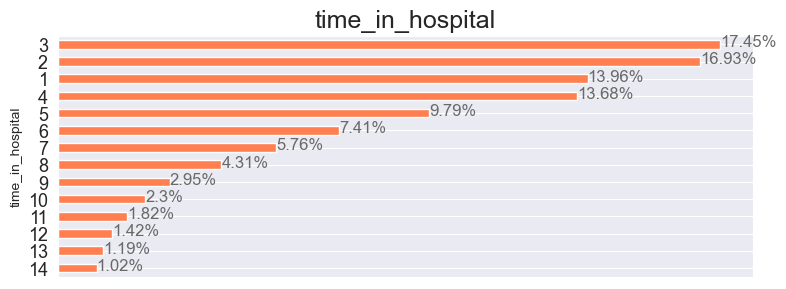

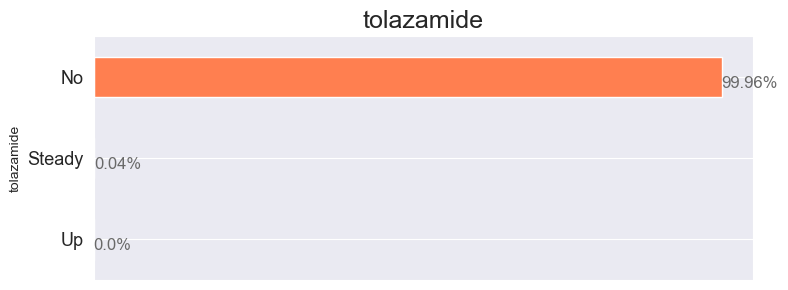

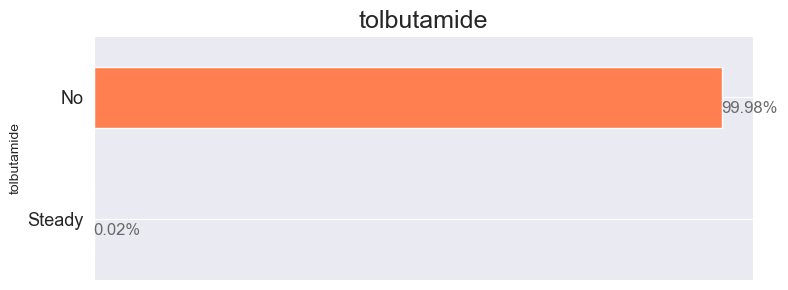

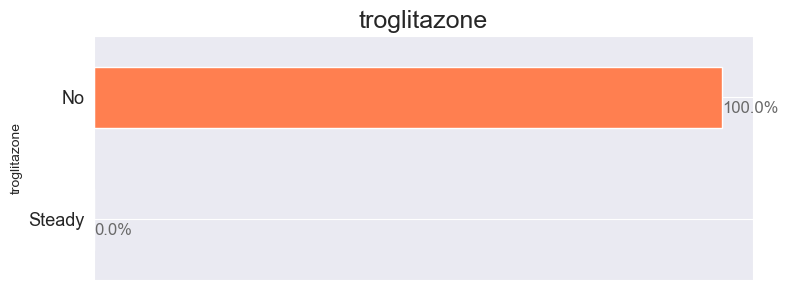

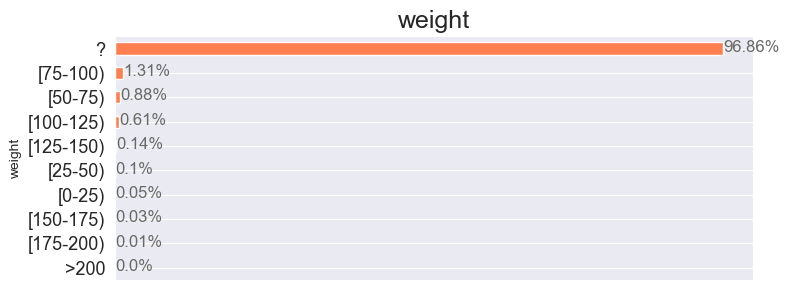

In [205]:
#Inspect value counts for each attribute
for col in df[df.columns.difference(['encounter_id', 'patient_nbr'])]:

    ax = df[col].value_counts().head(30).plot(kind='barh', figsize=(8,3),
                                            color="coral", fontsize=13);
    ax.set_alpha(0.8)
    ax.set_title(col, fontsize=18)
    #ax.set_xlabel("%s: %f " % ([col]),fontsize=18);
   
    ax.set_xticks([])

    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for i in ax.patches:
        totals.append(i.get_width())

    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    for i in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(i.get_width()+.3, i.get_y()+.38, \
                str(round((i.get_width()/total)*100, 2))+'%', fontsize=12,
    color='dimgrey')

    # invert for largest on top 
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show();
    

In [206]:
#preview the unique values from each column 
for col in df[df.columns.difference(['encounter_id', 'patient_nbr'])]:
    try:     
        print('\n',"-- %s --" % col,'\n',df[col].unique()[:30]) #if unique values are > 30
    except:
        print('\n',"-- %s --" % col,'\n',df[col].unique())


 -- A1Cresult -- 
 [nan '>7' '>8' 'Norm']

 -- acarbose -- 
 ['No' 'Steady' 'Up' 'Down']

 -- acetohexamide -- 
 ['No' 'Steady']

 -- admission_source_id -- 
 [ 1  7  2  4  5  6 20  3 17  8  9 14 10 22 11 25 13]

 -- admission_type_id -- 
 [6 1 2 3 4 5 8 7]

 -- age -- 
 ['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']

 -- change -- 
 ['No' 'Ch']

 -- chlorpropamide -- 
 ['No' 'Steady' 'Down' 'Up']

 -- citoglipton -- 
 ['No']

 -- diabetesMed -- 
 ['No' 'Yes']

 -- diag_1 -- 
 ['250.83' '276' '648' '8' '197' '414' '428' '398' '434' '250.7' '157'
 '518' '999' '410' '682' '402' '737' '572' 'V57' '189' '786' '427' '996'
 '277' '584' '462' '473' '411' '174' '486']

 -- diag_2 -- 
 ['?' '250.01' '250' '250.43' '157' '411' '492' '427' '198' '403' '288'
 '998' '507' '174' '425' '456' '401' '715' '496' '428' '585' '250.02'
 '410' '999' '996' '135' '244' '41' '571' '276']

 -- diag_3 -- 
 ['?' '255' 'V27' '403' '250' 'V45' '38' '486' '996

Relative Frequencies of Readmissions 
 readmitted
NO     0.54
>30    0.35
<30    0.11
Name: proportion, dtype: float64


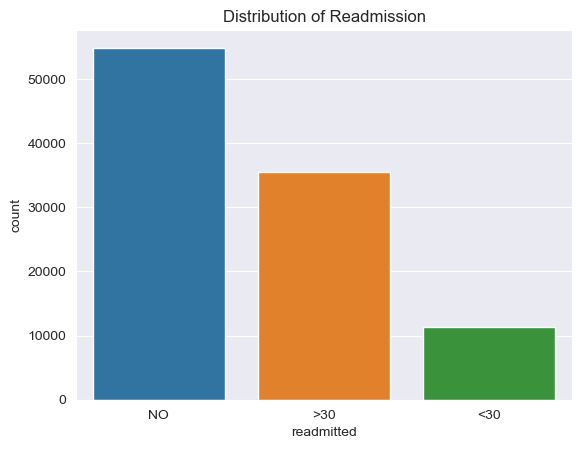

In [207]:
# The readmitted class distribution is our target variable. It tells us if a patient was hospitalized within 30 days, greater than 30 days or not readmitted.
print('Relative Frequencies of Readmissions','\n' , np.round(df['readmitted'].value_counts(normalize=True), decimals=2))
# Distribution of Readmission 

sns.countplot(x=df['readmitted']).set_title('Distribution of Readmission')

#Target(Outcome) Variable - prepare for binary classification
df.replace({'readmitted': {'NO': 0, '>30': 0, '<30': 1 }}, inplace=True)

In [208]:
# check values that are coded as "?" -missing values
column = []
cntcol = []
for col in df.columns:
    if df[col].dtype == object:
        column.append(col)
        cntcol.append(df[col][df[col] == '?'].count())
coln = pd.DataFrame({'Col': column, 'Count': cntcol})
coln[coln.Count != 0]

Col  Count
0               race   2273
3             weight  98569
4         payer_code  40256
5  medical_specialty  49949
6             diag_1     21
7             diag_2    358
8             diag_3   1423

In [209]:
#Generate descriptive statistics excluding the first 2 columns
np.round(df.describe(), decimals=2)
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [210]:
# Generate descriptive statistics and round to 2 decimal places
descriptive_stats = np.round(df.describe(), decimals=2)

# Display the result
print(descriptive_stats)

# Alternatively, you can use display to show it (in Jupyter Notebooks)
display(descriptive_stats)

       encounter_id   patient_nbr  admission_type_id  \
count  1.017660e+05  1.017660e+05          101766.00   
mean   1.652016e+08  5.433040e+07               2.02   
std    1.026403e+08  3.869636e+07               1.45   
min    1.252200e+04  1.350000e+02               1.00   
25%    8.496119e+07  2.341322e+07               1.00   
50%    1.523890e+08  4.550514e+07               1.00   
75%    2.302709e+08  8.754595e+07               3.00   
max    4.438672e+08  1.895026e+08               8.00   

       discharge_disposition_id  admission_source_id  time_in_hospital  \
count                 101766.00            101766.00         101766.00   
mean                       3.72                 5.75              4.40   
std                        5.28                 4.06              2.99   
min                        1.00                 1.00              1.00   
25%                        1.00                 1.00              2.00   
50%                        1.00                 7.0

encounter_id   patient_nbr  admission_type_id  \
count  1.017660e+05  1.017660e+05          101766.00   
mean   1.652016e+08  5.433040e+07               2.02   
std    1.026403e+08  3.869636e+07               1.45   
min    1.252200e+04  1.350000e+02               1.00   
25%    8.496119e+07  2.341322e+07               1.00   
50%    1.523890e+08  4.550514e+07               1.00   
75%    2.302709e+08  8.754595e+07               3.00   
max    4.438672e+08  1.895026e+08               8.00   

       discharge_disposition_id  admission_source_id  time_in_hospital  \
count                 101766.00            101766.00         101766.00   
mean                       3.72                 5.75              4.40   
std                        5.28                 4.06              2.99   
min                        1.00                 1.00              1.00   
25%                        1.00                 1.00              2.00   
50%                        1.00                 7.00              4.00   
75%                        4.00                 7.00              6.00   
max                       28.00                25.00             14.00   

       num_lab_procedures  num_procedures  num_medications  number_outpatient  \
count           101766.00       101766.00        101766.00          101766.00   
mean                43.10            1.34            16.02               0.37   
std                 19.67            1.71             8.13               1.27   
min                  1.00            0.00             1.00               0.00   
25%                 31.00            0.00            10.00               0.00   
50%                 44.00            1.00            15.00               0.00   
75%                 57.00            2.00            20.00               0.00   
max                132.00            6.00            81.00              42.00   

       number_emergency  number_inpatient  number_diagnoses  readmitted  
count         101766.00         101766.00         101766.00   101766.00  
mean               0.20              0.64              7.42        0.11  
std                0.93              1.26              1.93        0.31  
min                0.00              0.00              1.00        0.00  
25%                0.00              0.00              6.00        0.00  
50%                0.00              0.00              8.00        0.00  
75%                0.00              1.00              9.00        0.00  
max               76.00             21.00             16.00        1.00

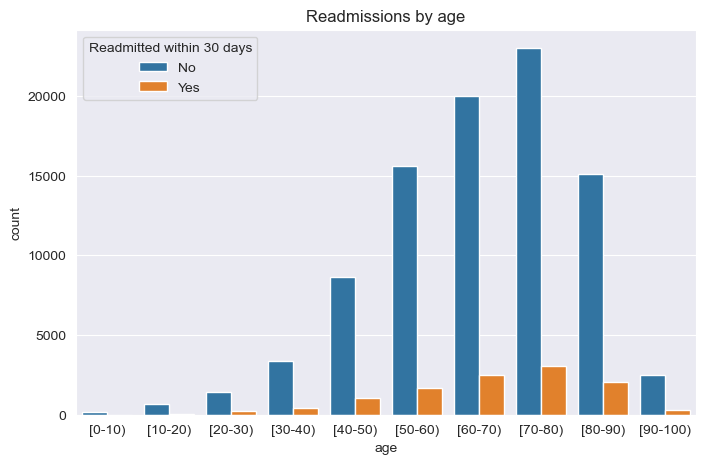

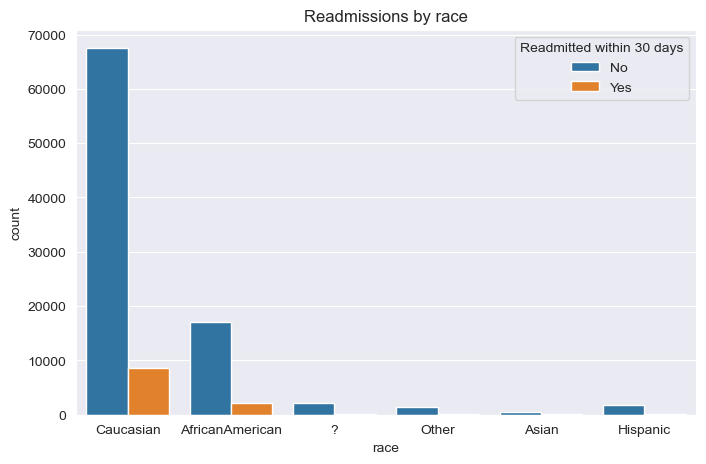

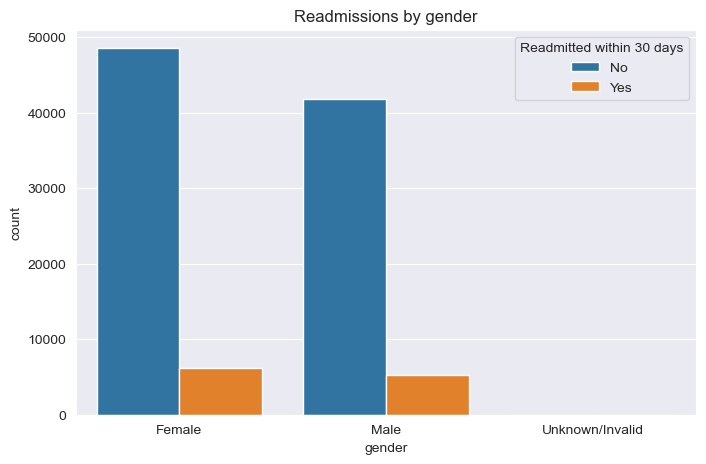

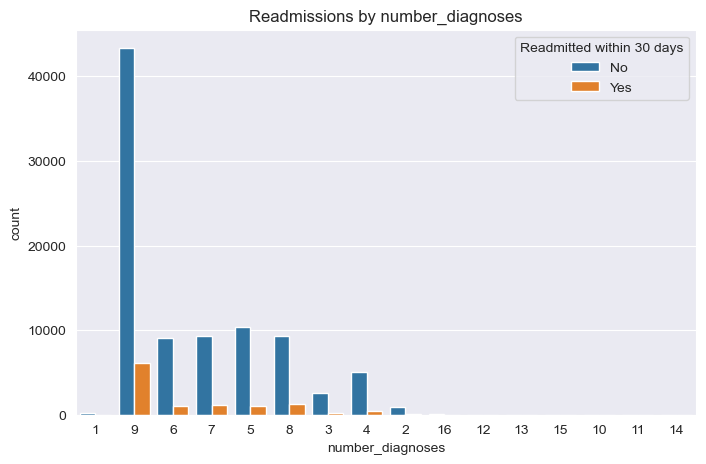

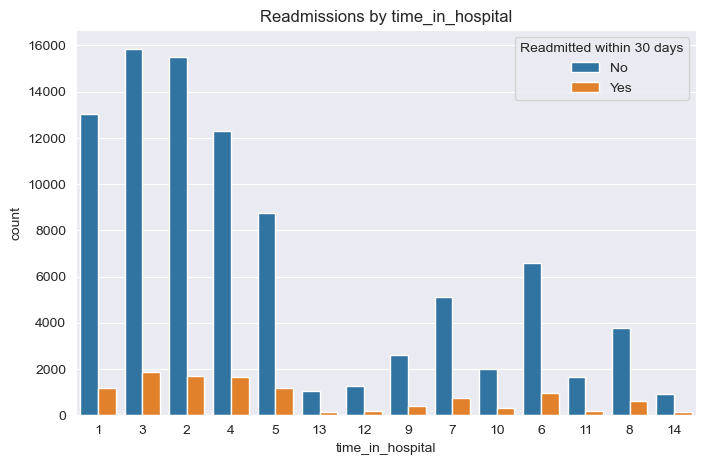

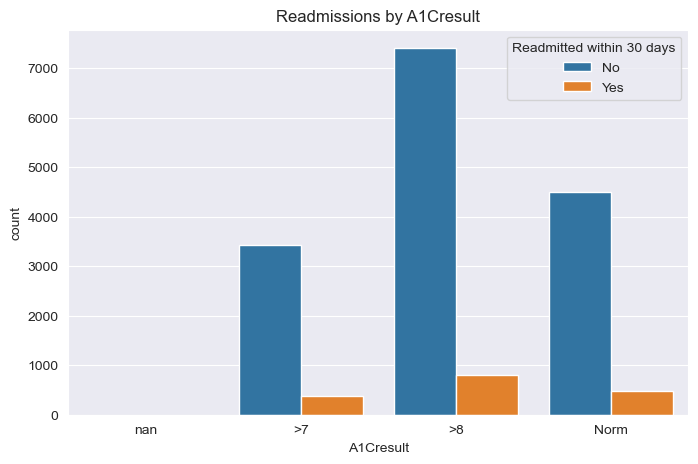

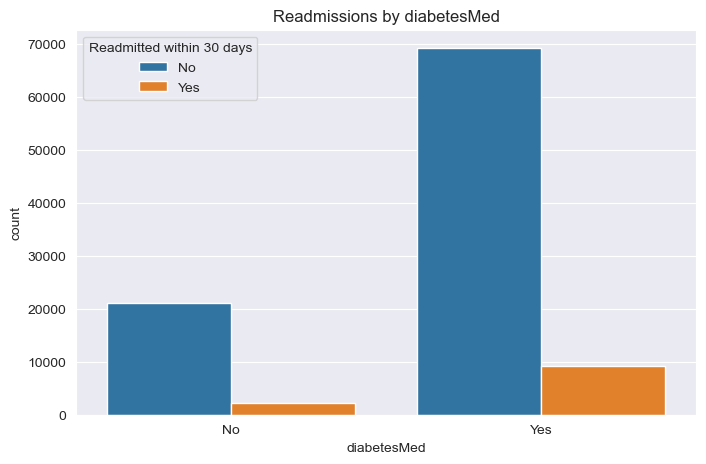

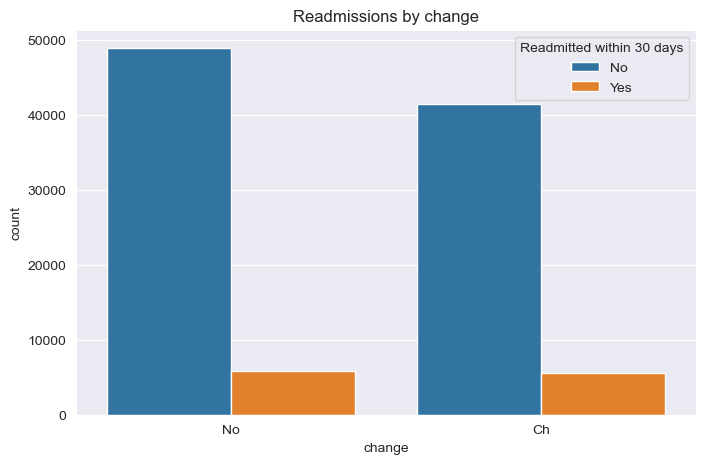

In [211]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'readmitted' is treated as categorical with 'Yes' and 'No'
df['readmitted'] = df['readmitted'].map({0: 'No', 1: 'Yes'})  # or use df['readmitted'].astype('category')

# List of columns to plot
cols = ['age', 'race', 'gender', 'number_diagnoses', 'time_in_hospital', 'A1Cresult', 'diabetesMed', 'change']

# Loop through columns to plot
for col in cols:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=col, hue='readmitted', data=df, order=df[col].unique())
    plt.title(f'Readmissions by {col}')
    plt.legend(title='Readmitted within 30 days', labels=('No', 'Yes'))
    plt.show()

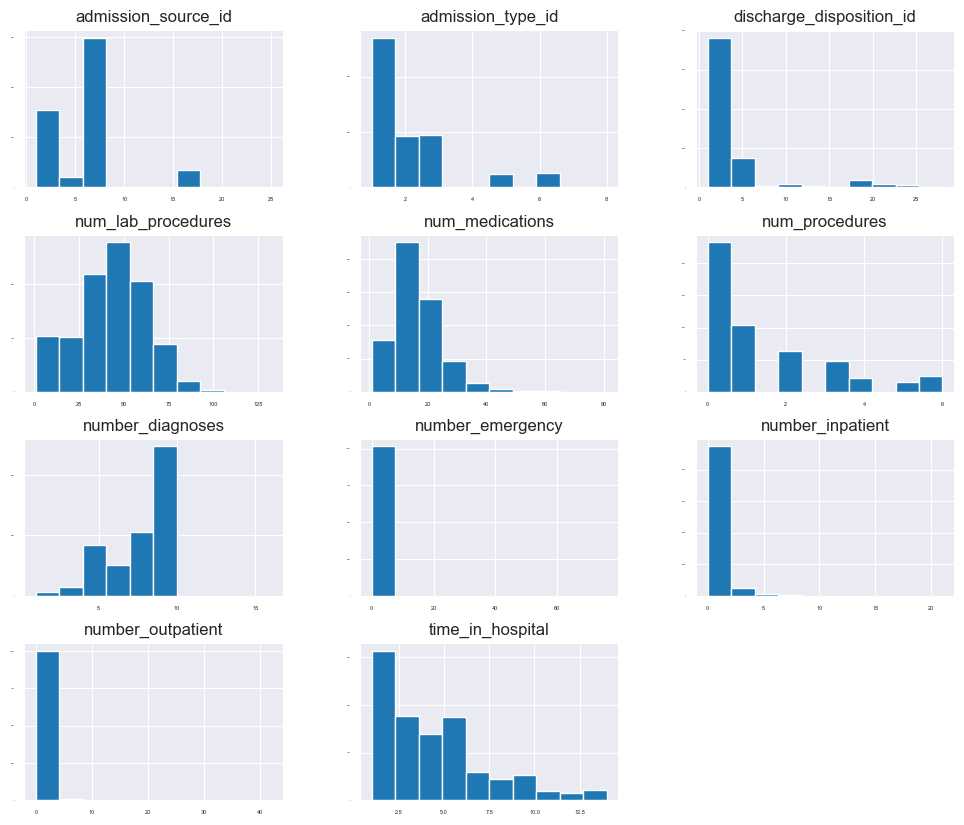

In [212]:
#Visualize the data distribution 
df[df.columns.difference(['encounter_id', 'patient_nbr'])].hist(sharex=False, sharey=False, xlabelsize=4, ylabelsize=1,figsize=(12, 10));

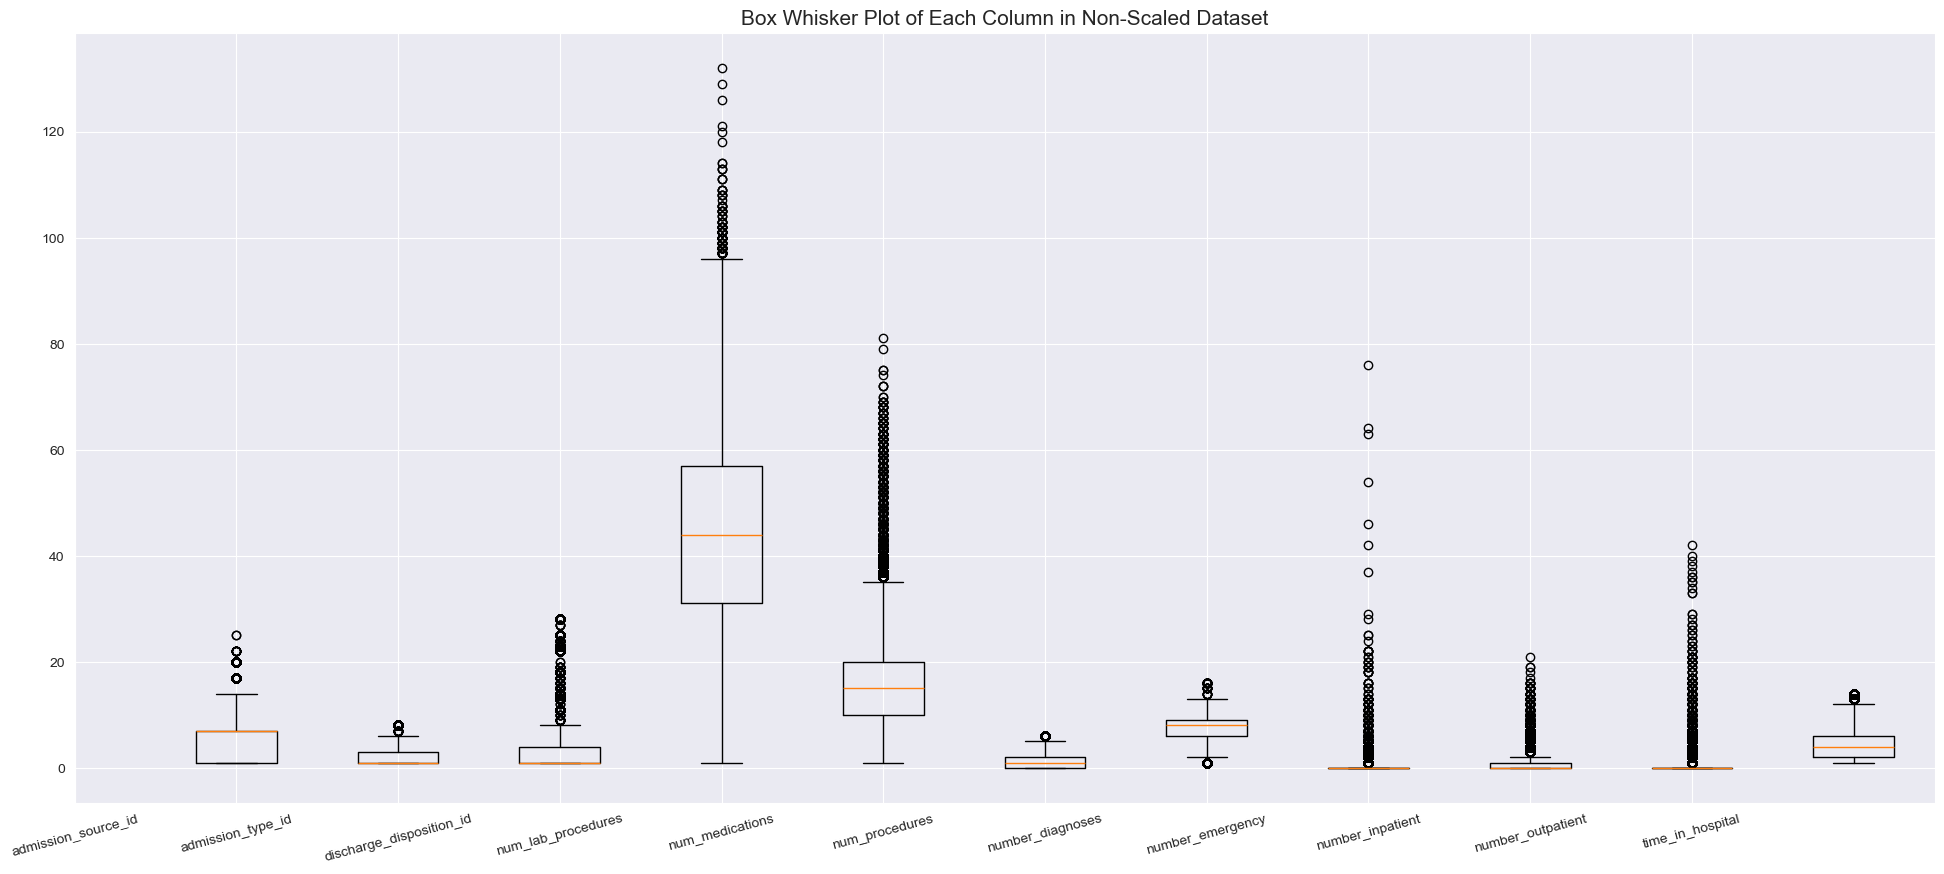

In [214]:
#Check the spread of values (standardize the data for modeling)
num_feat = df[df.columns.difference(['encounter_id', 'patient_nbr'])].select_dtypes(include=[np.number])
plt.figure(figsize=(24, 10))
plt.boxplot([num_feat[col] for col in num_feat.columns])
plt.title("Box Whisker Plot of Each Column in Non-Scaled Dataset", fontsize=15)
plt.xticks(range(len(num_feat.columns.values)), num_feat.columns.values, rotation = 15)
plt.show()

In [215]:
#Drop attributes with high percentage of Nulls. 
dfc = df.copy()
df.drop(['weight', 'payer_code', 'medical_specialty'],axis =1, inplace=True) 
df.shape

(101766, 47)

In [216]:
#delete attributes with same values (cardinality=1)
df.drop(['citoglipton', 'examide'], axis =1, inplace=True) 
df.shape

(101766, 45)

In [217]:
#drop rows with unknown gender
df = df[df.gender != 'Unknown/Invalid']
df.shape

(101763, 45)

In [218]:
print(df['discharge_disposition_id'].dtype)

int64


In [237]:
dcdisp = [11, 13, 14, 19, 20, 21]  # Keep as integers
df = df.loc[~df['discharge_disposition_id'].isin(dcdisp)]
print(df.shape)

(99340, 45)


In [239]:
# delete all rows with missing diagnosis
Dx = df[(df['diag_1'] == '?' ) | (df['diag_2'] == '?' ) | (df['diag_3'] == '?'  )].index
df.drop(Dx, inplace=True)
df.shape

(97822, 45)

In [241]:
# Change  ? race to 'Unknown'
df.replace({'race': {'?': 'Unknown'}}, inplace=True)

# Change admission type urgent and trauma into emergency
df['admission_type_id'].replace([2,7],1, inplace=True)     

# Change admission type Null and not mapped into not available (5)
df['admission_type_id'].replace([6,8],5, inplace=True)  

#Consolidate discharge disposition reason 
df['discharge_disposition_id'].replace([6, 8, 9],1, inplace=True)                                #Home
df['discharge_disposition_id'].replace([3, 4, 5, 15, 22, 23, 24, 27,30],2, inplace=True)         #Another facility
df['discharge_disposition_id'].replace([16, 17],12, inplace=True)                                #outpatient
df['discharge_disposition_id'].replace([25, 26],18, inplace=True)                                #null

#Consolidate admission source reason 
df['admission_source_id'].replace([2,3],1, inplace=True)                                     #Referral
df['admission_source_id'].replace([5, 6, 10, 18, 22, 25], 4, inplace=True)                   #transfer
df['admission_source_id'].replace([15, 17, 20, 21], 9, inplace=True)                         #not available
df['admission_source_id'].replace([12, 13, 14], 11, inplace=True)                            #delivery


In [243]:
#Get Systems for ICD9
def getICD(i):
    if 'V' in str(i) or 'E' in str(i):
        return 0
    i = float(i) 
    if (i >= 390 and i <= 459) or np.floor(i) == 785:
        return 1
    elif (i >= 460 and i <= 519) or np.floor(i) == 786:
        return 2
    elif (i >= 520 and i <= 579) or np.floor(i) == 787:
        return 3
    elif np.floor(i) == 250:
        return 4
    elif i >= 800 and i <= 999:
        return 5
    elif i >= 710 and i <= 739:
        return 6
    elif (i >= 580 and i <= 629) or np.floor(i) == 788:
        return 7
    elif i >= 140 and i <= 239:
        return 8
    else:
        return 0
    
#Get the ICD Categories for each ICD9. We will use only diag_1 as primary diagnosis    
df['ICDCat1'] = df['diag_1'].apply(lambda i: getICD(i))
#df['ICDCat2'] = df['diag_2'].apply(lambda i: getICD(i)).astype('object')
#df['ICDCat3'] = df['diag_3'].apply(lambda i: getICD(i)).astype('object')
df['ICDCat1'] = df['ICDCat1'].astype(int)
df[['diag_1','ICDCat1']].head(15).T


1    2  3    4    5    6    7    8    9      10   11   12   13   14  \
diag_1   276  648  8  197  414  414  428  398  434  250.7  157  428  428  518   
ICDCat1    0    0  0    8    1    1    1    1    1      4    8    1    1    2   

          15  
diag_1   999  
ICDCat1    5

In [245]:
#Add all prior inpatient, emergency and outpatient encounters in a new variable
df['num_encounters'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']

In [247]:
#Add a new variable by getting the total number of medication changes
meds = ['metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']

for m in meds:
    colname = str(m) + 'del'
    df[colname] = df[m].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)

    df['number_changes'] = 0


for m in meds:
    colname = str(m) + 'del'
    df['number_changes'] = df['number_changes'] + df[colname]
    del df[colname]
df['number_changes'].value_counts()

number_changes
0    71214
1    25214
2     1282
3      107
4        5
Name: count, dtype: int64

In [248]:
#Add a new variable by getting the total number of meds used during the encounter
for col in meds:
    df[col] = df[col].replace('No', 0)
    df[col] = df[col].replace('Steady', 1)
    df[col] = df[col].replace('Up', 1)
    df[col] = df[col].replace('Down', 1) 

df['number_meds'] = 0
for col in meds:
    df['number_meds'] = df['number_meds'] + df[col]
df['number_meds'].value_counts()

number_meds
1    45205
0    22311
2    21314
3     7616
4     1313
5       58
6        5
Name: count, dtype: int64

In [250]:
#Get the median of the age group to create a new numeric variable to see the effect of increasing age on readmission
#Rename age to age-group
df.rename(columns={"age": "age_group"}, inplace=True)

age_id = {'[0-10)':5, 
          '[10-20)':15, 
          '[20-30)':25, 
          '[30-40)':35, 
          '[40-50)':45, 
          '[50-60)':55,
          '[60-70)':65, 
          '[70-80)':75, 
          '[80-90)':85, 
          '[90-100)':95}
df['age'] = df.age_group.replace(age_id)


In [253]:

#Organize the Categorical Variables
df.replace({'gender': {'Male': 1, 'Female' : 0}}, inplace=True)
df.replace({'change': {'Ch': 1, 'No' : 0}}, inplace=True)
df.replace({'diabetesMed': {'Yes': 1, 'No' : 0}}, inplace=True)

df.replace({'A1Cresult': {'>7': 2, '>8': 2, 'Norm': 1, 'None' : 0 }}, inplace=True)
df.replace({'max_glu_serum': {'>200': 2, '>300': 2, 'Norm': 1, 'None' : 0 }}, inplace=True)



In [255]:
pd.options.display.max_columns = 50
display(df.head(), df.info())
df.shape

<class 'pandas.core.frame.DataFrame'>
Index: 97822 entries, 1 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   encounter_id              97822 non-null  int64  
 1   patient_nbr               97822 non-null  int64  
 2   race                      97822 non-null  object 
 3   gender                    97822 non-null  int64  
 4   age_group                 97822 non-null  object 
 5   admission_type_id         97822 non-null  int64  
 6   discharge_disposition_id  97822 non-null  int64  
 7   admission_source_id       97822 non-null  int64  
 8   time_in_hospital          97822 non-null  int64  
 9   num_lab_procedures        97822 non-null  int64  
 10  num_procedures            97822 non-null  int64  
 11  num_medications           97822 non-null  int64  
 12  number_outpatient         97822 non-null  int64  
 13  number_emergency          97822 non-null  int64  
 14  number_inp

encounter_id  patient_nbr             race  gender age_group  \
1        149190     55629189        Caucasian       0   [10-20)   
2         64410     86047875  AfricanAmerican       0   [20-30)   
3        500364     82442376        Caucasian       1   [30-40)   
4         16680     42519267        Caucasian       1   [40-50)   
5         35754     82637451        Caucasian       1   [50-60)   

   admission_type_id  discharge_disposition_id  admission_source_id  \
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   
5                  1                         1                    1   

   time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
1                 3                  59               0               18   
2                 2                  11               5               13   
3                 2                  44               1               16   
4                 1                  51               0                8   
5                 3                  31               6               16   

   number_outpatient  number_emergency  number_inpatient diag_1  diag_2  \
1                  0                 0                 0    276  250.01   
2                  2                 0                 1    648     250   
3                  0                 0                 0      8  250.43   
4                  0                 0                 0    197     157   
5                  0                 0                 0    414     411   

  diag_3  number_diagnoses  max_glu_serum  A1Cresult  metformin  repaglinide  \
1    255                 9            NaN        NaN          0            0   
2    V27                 6            NaN        NaN          0            0   
3    403                 7            NaN        NaN          0            0   
4    250                 5            NaN        NaN          0            0   
5    250                 9            NaN        NaN          0            0   

   nateglinide  chlorpropamide  glimepiride  acetohexamide  glipizide  \
1            0               0            0              0          0   
2            0               0            0              0          1   
3            0               0            0              0          0   
4            0               0            0              0          1   
5            0               0            0              0          0   

   glyburide  tolbutamide  pioglitazone  rosiglitazone  acarbose  miglitol  \
1          0            0             0              0         0         0   
2          0            0             0              0         0         0   
3          0            0             0              0         0         0   
4          0            0             0              0         0         0   
5          0            0             0              0         0         0   

   troglitazone  tolazamide  insulin  glyburide-metformin  \
1             0           0        1                    0   
2             0           0        0                    0   
3             0           0        1                    0   
4             0           0        1                    0   
5             0           0        1                    0   

   glipizide-metformin  glimepiride-pioglitazone  metformin-rosiglitazone  \
1                    0                         0                        0   
2                    0                         0                        0   
3                    0                         0                        0   
4                    0                         0                        0   
5                    0                         0                        0   

   metformin-pioglitazone  change  diabetesMed

None

(97822, 50)

In [257]:
#Change data type to object for categorical features
cat_feat = ['encounter_id', 'patient_nbr','gender','admission_source_id','admission_type_id','discharge_disposition_id','max_glu_serum','A1Cresult'
            ,'change', 'diabetesMed' , 'ICDCat1','metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', \
          'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', \
          'acarbose','miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin',  \
          'glipizide-metformin','glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']
df[cat_feat] = df[cat_feat].astype('object')


In [259]:

#creating a list of categorical and numeric columns names

categorical=df.select_dtypes(include=['object'])
numeric=df.select_dtypes(exclude=['object'])
 
#numeric_var=list(set(list(df.select_dtypes(exclude=['object'])-{'readmitted'})
print(categorical.columns.values)
print(numeric.columns.values)
numeric_vars = numeric.drop(['readmitted'], axis=1, errors='ignore')
numerics = numeric_vars.columns.tolist()

['encounter_id' 'patient_nbr' 'race' 'gender' 'age_group'
 'admission_type_id' 'discharge_disposition_id' 'admission_source_id'
 'diag_1' 'diag_2' 'diag_3' 'max_glu_serum' 'A1Cresult' 'metformin'
 'repaglinide' 'nateglinide' 'chlorpropamide' 'glimepiride'
 'acetohexamide' 'glipizide' 'glyburide' 'tolbutamide' 'pioglitazone'
 'rosiglitazone' 'acarbose' 'miglitol' 'troglitazone' 'tolazamide'
 'insulin' 'glyburide-metformin' 'glipizide-metformin'
 'glimepiride-pioglitazone' 'metformin-rosiglitazone'
 'metformin-pioglitazone' 'change' 'diabetesMed' 'readmitted' 'ICDCat1']
['time_in_hospital' 'num_lab_procedures' 'num_procedures'
 'num_medications' 'number_outpatient' 'number_emergency'
 'number_inpatient' 'number_diagnoses' 'num_encounters' 'number_changes'
 'number_meds' 'age']


In [260]:
#Let's check % of outliers https://www.kaggle.com/prasadperera/the-boston-housing-dataset
print('\n',"=================== Outliers =======================") 
for k, v in numeric.items():
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(df)[0]
        print(" %s outliers = %.2f%%" % (k, perc))
#Let's check skewness & kurtosis        
print('\n',"===================Skewness & Kurtosis =======================")       

for col in numeric:    
    print (col, "Skew is:", numeric[col].skew(), "Kurtosis is:", numeric[col].kurtosis())


 =================== Outliers =======================
 time_in_hospital outliers = 3.60%
 num_lab_procedures outliers = 0.15%
 num_procedures outliers = 7.93%
 num_medications outliers = 3.33%
 number_outpatient outliers = 100.00%
 number_emergency outliers = 100.00%
 number_inpatient outliers = 6.90%
 number_diagnoses outliers = 0.06%
 num_encounters outliers = 6.40%
 number_changes outliers = 0.11%
 number_meds outliers = 1.41%
 age outliers = 2.08%

 ===================Skewness & Kurtosis =======================
time_in_hospital Skew is: 1.1317664085311465 Kurtosis is: 0.8582730881673455
num_lab_procedures Skew is: -0.24250501129092308 Kurtosis is: -0.250823765661782
num_procedures Skew is: 1.3104474629629455 Kurtosis is: 0.8391960506284928
num_medications Skew is: 1.3458559624681155 Kurtosis is: 3.5698100578576715
number_outpatient Skew is: 8.81340693404269 Kurtosis is: 147.9359520324741
number_emergency Skew is: 22.89253674859365 Kurtosis is: 1184.2901033784879
number_inpatient S

In [263]:
# Perform logarithmic transformation to reduce skewness and decrease variability of data

df['number_inpatient_log'] = np.log1p(df['number_inpatient'])
df['number_emergency_log']  = np.log1p(df['number_emergency'])
df['number_outpatient_log']  = np.log1p(df['number_outpatient'])
df['num_encounters_log']  = np.log1p(df['num_encounters'])

pd.options.display.max_columns = 60
df.head()

encounter_id patient_nbr             race gender age_group  \
1       149190    55629189        Caucasian      0   [10-20)   
2        64410    86047875  AfricanAmerican      0   [20-30)   
3       500364    82442376        Caucasian      1   [30-40)   
4        16680    42519267        Caucasian      1   [40-50)   
5        35754    82637451        Caucasian      1   [50-60)   

  admission_type_id discharge_disposition_id admission_source_id  \
1                 1                        1                   7   
2                 1                        1                   7   
3                 1                        1                   7   
4                 1                        1                   7   
5                 1                        1                   1   

   time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
1                 3                  59               0               18   
2                 2                  11               5               13   
3                 2                  44               1               16   
4                 1                  51               0                8   
5                 3                  31               6               16   

   number_outpatient  number_emergency  number_inpatient diag_1  diag_2  \
1                  0                 0                 0    276  250.01   
2                  2                 0                 1    648     250   
3                  0                 0                 0      8  250.43   
4                  0                 0                 0    197     157   
5                  0                 0                 0    414     411   

  diag_3  number_diagnoses max_glu_serum A1Cresult metformin repaglinide  \
1    255                 9           NaN       NaN         0           0   
2    V27                 6           NaN       NaN         0           0   
3    403                 7           NaN       NaN         0           0   
4    250                 5           NaN       NaN         0           0   
5    250                 9           NaN       NaN         0           0   

  nateglinide chlorpropamide glimepiride acetohexamide glipizide glyburide  \
1           0              0           0             0         0         0   
2           0              0           0             0         1         0   
3           0              0           0             0         0         0   
4           0              0           0             0         1         0   
5           0              0           0             0         0         0   

  tolbutamide pioglitazone rosiglitazone acarbose miglitol troglitazone  \
1           0            0             0        0        0            0   
2           0            0             0        0        0            0   
3           0            0             0        0        0            0   
4           0            0             0        0        0            0   
5           0            0             0        0        0            0   

  tolazamide insulin glyburide-metformin glipizide-metformin  \
1          0       1                   0                   0   
2          0       0                   0                   0   
3          0       1                   0                   0   
4          0       1                   0                   0   
5          0       1                   0                   0   

  glimepiride-pioglitazone metformin-rosiglitazone metformin-pioglitazone  \
1                        0                       0                      0   
2                        0                       0                      0   
3                        0                       0                      0   
4                        0                       0                      0   
5                        0                       0                      0   

  change diabetesMed readmitted ICDCat1  num_encounters  number_changes  \


In [265]:
#Drop the original features before transformation
print(df.shape)
df = df.drop(['number_outpatient', 'number_inpatient', 'number_emergency','num_encounters'], axis = 1)
df.shape

(97822, 54)


(97822, 50)

In [267]:
df.drop(['diag_1', 'diag_2', 'diag_3'], axis=1, inplace=True)

In [269]:
dfcopy = df.copy(deep = True)

In [270]:
df = dfcopy.copy(deep = True)

In [273]:
#Check for duplicate encounters and remove
display(df.shape)
enc = df['encounter_id']
display(df[enc.isin(enc[enc.duplicated()])])

enc = df['encounter_id']
df[enc.duplicated()]

display(df.shape)

(97822, 47)

Empty DataFrame
Columns: [encounter_id, patient_nbr, race, gender, age_group, admission_type_id, discharge_disposition_id, admission_source_id, time_in_hospital, num_lab_procedures, num_procedures, num_medications, number_diagnoses, max_glu_serum, A1Cresult, metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone, tolazamide, insulin, glyburide-metformin, glipizide-metformin, glimepiride-pioglitazone, metformin-rosiglitazone, metformin-pioglitazone, change, diabetesMed, readmitted, ICDCat1, number_changes, number_meds, age, number_inpatient_log, number_emergency_log, number_outpatient_log, num_encounters_log]
Index: []

(97822, 47)

In [275]:
#Find duplicate patients and remove except for the first occurrence 

patients = df['patient_nbr']
df[patients.isin(patients[patients.duplicated()])]

df2 = df.loc[~df.patient_nbr.duplicated(keep='first')]
df2.shape

(68885, 47)

In [276]:
numeric=df2.select_dtypes(exclude=['object'])
 
numeric_vars = numeric.drop(['readmitted'], axis=1, errors='ignore')
numerics = numeric_vars.columns.tolist()

In [279]:
df2.describe()

time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
count      68885.000000        68885.000000    68885.000000     68885.000000   
mean           4.301227           42.955898        1.439167        15.774218   
std            2.941826           19.919356        1.763318         8.276767   
min            1.000000            1.000000        0.000000         1.000000   
25%            2.000000           31.000000        0.000000        10.000000   
50%            4.000000           44.000000        1.000000        14.000000   
75%            6.000000           57.000000        2.000000        20.000000   
max           14.000000          132.000000        6.000000        81.000000   

       number_diagnoses  number_changes   number_meds           age  \
count      68885.000000    68885.000000  68885.000000  68885.000000   
mean           7.310576        0.262002      1.191348     65.793642   
std            1.898289        0.476121      0.944245     15.572944   
min            3.000000        0.000000      0.000000      5.000000   
25%            6.000000        0.000000      1.000000     55.000000   
50%            8.000000        0.000000      1.000000     65.000000   
75%            9.000000        0.000000      2.000000     75.000000   
max           16.000000        4.000000      6.000000     95.000000   

       number_inpatient_log  number_emergency_log  number_outpatient_log  \
count          68885.000000          68885.000000           68885.000000   
mean               0.103550              0.061124               0.135318   
std                0.298941              0.230229               0.381502   
min                0.000000              0.000000               0.000000   
25%                0.000000              0.000000               0.000000   
50%                0.000000              0.000000               0.000000   
75%                0.000000              0.000000               0.000000   
max                2.564949              3.761200               3.761200   

       num_encounters_log  
count        68885.000000  
mean             0.271864  
std              0.506302  
min              0.000000  
25%              0.000000  
50%              0.000000  
75%              0.693147  
max              3.912023

In [281]:
# Remove outliers that are outside 3 standard deviation from either side of the mean (0.3%)
#Outlier prohibit the model to estimate the true relationship between variables by introducing bias.
print(df2.shape)
df2 = df2[(np.abs(sp.stats.zscore(df2[numerics])) < 3).all(axis=1)]
df2.shape


(68885, 47)


(60535, 47)

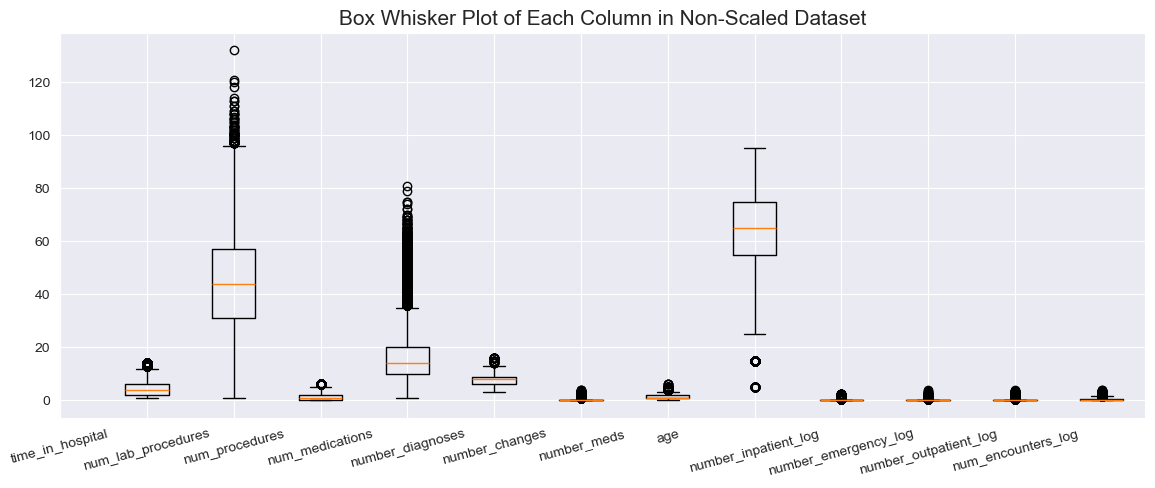

In [283]:
#Re-check the spread of values (standardize the data for modeling)
#num_feat = df[df.columns.difference(['encounter_id', 'patient_nbr'])].select_dtypes(include=[np.number])
plt.figure(figsize=(14, 5))
plt.boxplot([numeric[col] for col in numeric.columns])
plt.title("Box Whisker Plot of Each Column in Non-Scaled Dataset", fontsize=15)
plt.xticks(range(len(numeric.columns.values)), numeric.columns.values, rotation = 15)
plt.show()

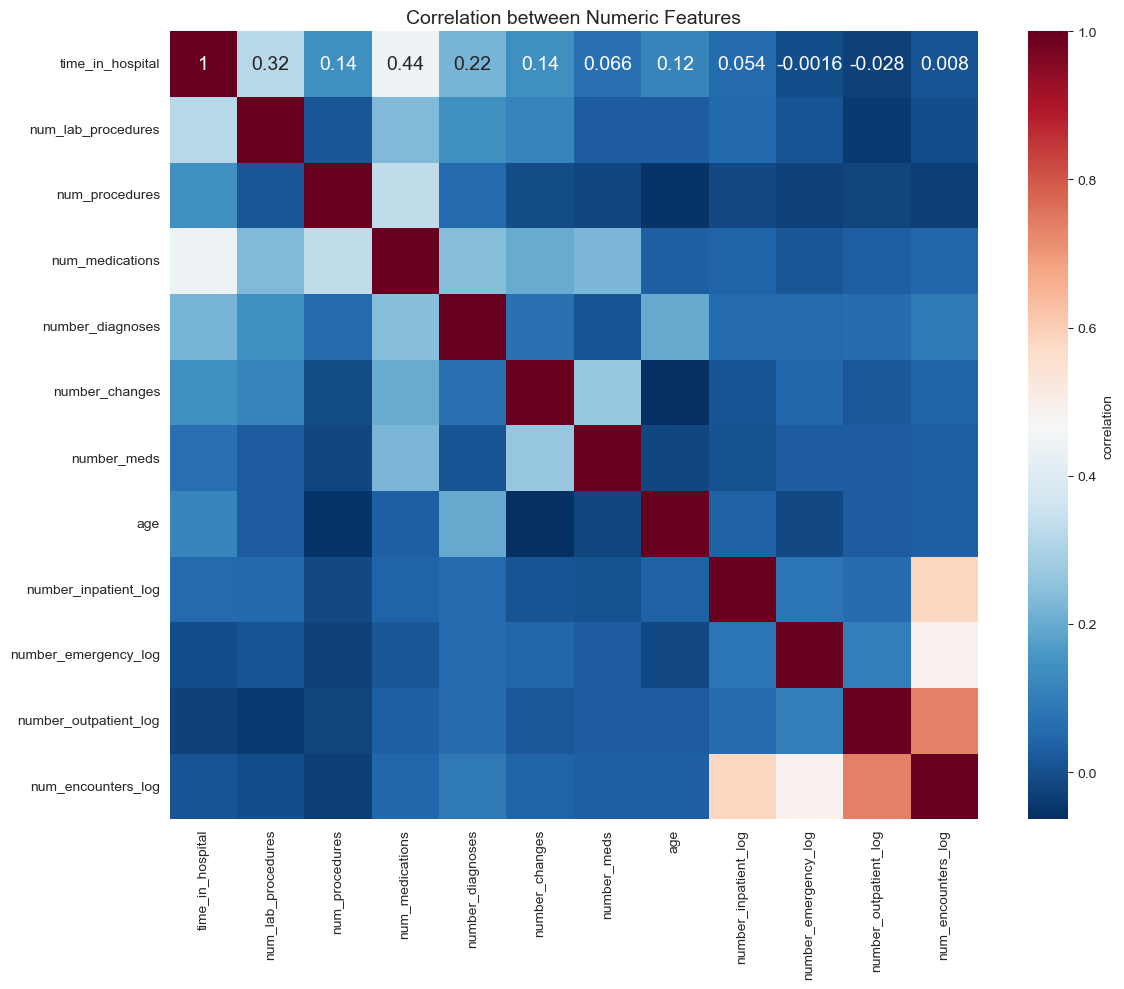

In [285]:
# Extract numeric columns
numeric = df2.select_dtypes(include=['number'])

# Now you can calculate the correlation and create the heatmap
plt.figure(figsize=(12,10))
sns.heatmap(numeric.corr(), cmap='RdBu_r', annot=True, annot_kws={'size': 14},
            cbar=True, cbar_kws={'label': 'correlation'})
plt.title('Correlation between Numeric Features', fontdict={'fontsize': 14})
plt.tight_layout()
plt.show()


In [287]:
df2.head(5)

encounter_id patient_nbr             race gender age_group  \
2        64410    86047875  AfricanAmerican      0   [20-30)   
3       500364    82442376        Caucasian      1   [30-40)   
4        16680    42519267        Caucasian      1   [40-50)   
5        35754    82637451        Caucasian      1   [50-60)   
6        55842    84259809        Caucasian      1   [60-70)   

  admission_type_id discharge_disposition_id admission_source_id  \
2                 1                        1                   7   
3                 1                        1                   7   
4                 1                        1                   7   
5                 1                        1                   1   
6                 3                        1                   1   

   time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
2                 2                  11               5               13   
3                 2                  44               1               16   
4                 1                  51               0                8   
5                 3                  31               6               16   
6                 4                  70               1               21   

   number_diagnoses max_glu_serum A1Cresult metformin repaglinide nateglinide  \
2                 6           NaN       NaN         0           0           0   
3                 7           NaN       NaN         0           0           0   
4                 5           NaN       NaN         0           0           0   
5                 9           NaN       NaN         0           0           0   
6                 7           NaN       NaN         1           0           0   

  chlorpropamide glimepiride acetohexamide glipizide glyburide tolbutamide  \
2              0           0             0         1         0           0   
3              0           0             0         0         0           0   
4              0           0             0         1         0           0   
5              0           0             0         0         0           0   
6              0           1             0         0         0           0   

  pioglitazone rosiglitazone acarbose miglitol troglitazone tolazamide  \
2            0             0        0        0            0          0   
3            0             0        0        0            0          0   
4            0             0        0        0            0          0   
5            0             0        0        0            0          0   
6            0             0        0        0            0          0   

  insulin glyburide-metformin glipizide-metformin glimepiride-pioglitazone  \
2       0                   0                   0                        0   
3       1                   0                   0                        0   
4       1                   0                   0                        0   
5       1                   0                   0                        0   
6       1                   0                   0                        0   

  metformin-rosiglitazone metformin-pioglitazone change diabetesMed  \
2                       0                      0      0           1   
3                       0                      0      1           1   
4                       0                      0      1           1   
5                       0                      0      0           1   
6                       0                      0      1           1   

  readmitted ICDCat1  number_changes  number_meds  age  number_inpatient_log  \
2         No       0               0            1   25              0.693147   
3         No       0               1            1   35              0.000000   
4         No       8               0            2   45              0.000000   
5         No       1               0            1   55              0.000000   
6         No       1               0            3   65

In [289]:
df.head(5)

encounter_id patient_nbr             race gender age_group  \
1       149190    55629189        Caucasian      0   [10-20)   
2        64410    86047875  AfricanAmerican      0   [20-30)   
3       500364    82442376        Caucasian      1   [30-40)   
4        16680    42519267        Caucasian      1   [40-50)   
5        35754    82637451        Caucasian      1   [50-60)   

  admission_type_id discharge_disposition_id admission_source_id  \
1                 1                        1                   7   
2                 1                        1                   7   
3                 1                        1                   7   
4                 1                        1                   7   
5                 1                        1                   1   

   time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
1                 3                  59               0               18   
2                 2                  11               5               13   
3                 2                  44               1               16   
4                 1                  51               0                8   
5                 3                  31               6               16   

   number_diagnoses max_glu_serum A1Cresult metformin repaglinide nateglinide  \
1                 9           NaN       NaN         0           0           0   
2                 6           NaN       NaN         0           0           0   
3                 7           NaN       NaN         0           0           0   
4                 5           NaN       NaN         0           0           0   
5                 9           NaN       NaN         0           0           0   

  chlorpropamide glimepiride acetohexamide glipizide glyburide tolbutamide  \
1              0           0             0         0         0           0   
2              0           0             0         1         0           0   
3              0           0             0         0         0           0   
4              0           0             0         1         0           0   
5              0           0             0         0         0           0   

  pioglitazone rosiglitazone acarbose miglitol troglitazone tolazamide  \
1            0             0        0        0            0          0   
2            0             0        0        0            0          0   
3            0             0        0        0            0          0   
4            0             0        0        0            0          0   
5            0             0        0        0            0          0   

  insulin glyburide-metformin glipizide-metformin glimepiride-pioglitazone  \
1       1                   0                   0                        0   
2       0                   0                   0                        0   
3       1                   0                   0                        0   
4       1                   0                   0                        0   
5       1                   0                   0                        0   

  metformin-rosiglitazone metformin-pioglitazone change diabetesMed  \
1                       0                      0      1           1   
2                       0                      0      0           1   
3                       0                      0      1           1   
4                       0                      0      1           1   
5                       0                      0      0           1   

  readmitted ICDCat1  number_changes  number_meds  age  number_inpatient_log  \
1         No       0               1            1   15              0.000000   
2         No       0               0            1   25              0.693147   
3         No       0               1            1   35              0.000000   
4         No       8               0            2   45              0.000000   
5         No       1               0            1   55

In [291]:
df2.shape

(60535, 47)

In [293]:
df.shape

(97822, 47)

In [295]:
df2.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age_group',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'ICDCat1', 'number_changes', 'number_meds', 'age',
       'number_inpatient_log', 'number_emergency_log', 'number_outpatient_log',
       'num_encounters_log'],
      dtype='object')

In [297]:
#We will drop one of independent variables that are highly correlated to each other. 
df2.drop(['number_outpatient_log'], axis=1, inplace=True)

In [299]:
import pandas as pd

# Select only numeric columns
df2_numeric = df2.select_dtypes(include=['number', 'float', 'int'])

# Calculate correlation matrix
c = df2_numeric.corr().abs()

# Unstack the table
s = c.unstack()

# Sort the values in descending order
so = s.sort_values(ascending=False)

# Remove self-correlations (1.0)
so = so[so < 1]

# Display the most relevant part of the list
print(so.head(200))


num_encounters_log    number_inpatient_log    0.581748
number_inpatient_log  num_encounters_log      0.581748
num_encounters_log    number_emergency_log    0.490448
number_emergency_log  num_encounters_log      0.490448
time_in_hospital      num_medications         0.439897
                                                ...   
number_inpatient_log  number_meds             0.003784
number_emergency_log  time_in_hospital        0.001562
time_in_hospital      number_emergency_log    0.001562
num_encounters_log    num_lab_procedures      0.001539
num_lab_procedures    num_encounters_log      0.001539
Length: 110, dtype: float64


In [301]:
print(df2.shape)

data1=df2.copy(deep=True)
data1.to_csv('processed_predum_data.csv', index=False)
data1.head(5)

(60535, 46)


encounter_id patient_nbr             race gender age_group  \
2        64410    86047875  AfricanAmerican      0   [20-30)   
3       500364    82442376        Caucasian      1   [30-40)   
4        16680    42519267        Caucasian      1   [40-50)   
5        35754    82637451        Caucasian      1   [50-60)   
6        55842    84259809        Caucasian      1   [60-70)   

  admission_type_id discharge_disposition_id admission_source_id  \
2                 1                        1                   7   
3                 1                        1                   7   
4                 1                        1                   7   
5                 1                        1                   1   
6                 3                        1                   1   

   time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
2                 2                  11               5               13   
3                 2                  44               1               16   
4                 1                  51               0                8   
5                 3                  31               6               16   
6                 4                  70               1               21   

   number_diagnoses max_glu_serum A1Cresult metformin repaglinide nateglinide  \
2                 6           NaN       NaN         0           0           0   
3                 7           NaN       NaN         0           0           0   
4                 5           NaN       NaN         0           0           0   
5                 9           NaN       NaN         0           0           0   
6                 7           NaN       NaN         1           0           0   

  chlorpropamide glimepiride acetohexamide glipizide glyburide tolbutamide  \
2              0           0             0         1         0           0   
3              0           0             0         0         0           0   
4              0           0             0         1         0           0   
5              0           0             0         0         0           0   
6              0           1             0         0         0           0   

  pioglitazone rosiglitazone acarbose miglitol troglitazone tolazamide  \
2            0             0        0        0            0          0   
3            0             0        0        0            0          0   
4            0             0        0        0            0          0   
5            0             0        0        0            0          0   
6            0             0        0        0            0          0   

  insulin glyburide-metformin glipizide-metformin glimepiride-pioglitazone  \
2       0                   0                   0                        0   
3       1                   0                   0                        0   
4       1                   0                   0                        0   
5       1                   0                   0                        0   
6       1                   0                   0                        0   

  metformin-rosiglitazone metformin-pioglitazone change diabetesMed  \
2                       0                      0      0           1   
3                       0                      0      1           1   
4                       0                      0      1           1   
5                       0                      0      0           1   
6                       0                      0      1           1   

  readmitted ICDCat1  number_changes  number_meds  age  number_inpatient_log  \
2         No       0               0            1   25              0.693147   
3         No       0               1            1   35              0.000000   
4         No       8               0            2   45              0.000000   
5         No       1               0            1   55              0.000000   
6         No       1               0            3   65

In [302]:

df = pd.get_dummies(df2, columns=['race', 'gender', 'admission_type_id', 'discharge_disposition_id',
                                      'admission_source_id', 'max_glu_serum', 'A1Cresult', 'ICDCat1', 'diabetesMed','change'], drop_first = True)
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60535 entries, 2 to 101765
Data columns (total 68 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   encounter_id                 60535 non-null  object 
 1   patient_nbr                  60535 non-null  object 
 2   age_group                    60535 non-null  object 
 3   time_in_hospital             60535 non-null  int64  
 4   num_lab_procedures           60535 non-null  int64  
 5   num_procedures               60535 non-null  int64  
 6   num_medications              60535 non-null  int64  
 7   number_diagnoses             60535 non-null  int64  
 8   metformin                    60535 non-null  object 
 9   repaglinide                  60535 non-null  object 
 10  nateglinide                  60535 non-null  object 
 11  chlorpropamide               60535 non-null  object 
 12  glimepiride                  60535 non-null  object 
 13  acetohexamide       

In [304]:

pd.options.display.max_columns = 900
display(df.head())
df.info()


encounter_id patient_nbr age_group  time_in_hospital  num_lab_procedures  \
2        64410    86047875   [20-30)                 2                  11   
3       500364    82442376   [30-40)                 2                  44   
4        16680    42519267   [40-50)                 1                  51   
5        35754    82637451   [50-60)                 3                  31   
6        55842    84259809   [60-70)                 4                  70   

   num_procedures  num_medications  number_diagnoses metformin repaglinide  \
2               5               13                 6         0           0   
3               1               16                 7         0           0   
4               0                8                 5         0           0   
5               6               16                 9         0           0   
6               1               21                 7         1           0   

  nateglinide chlorpropamide glimepiride acetohexamide glipizide glyburide  \
2           0              0           0             0         1         0   
3           0              0           0             0         0         0   
4           0              0           0             0         1         0   
5           0              0           0             0         0         0   
6           0              0           1             0         0         0   

  tolbutamide pioglitazone rosiglitazone acarbose miglitol troglitazone  \
2           0            0             0        0        0            0   
3           0            0             0        0        0            0   
4           0            0             0        0        0            0   
5           0            0             0        0        0            0   
6           0            0             0        0        0            0   

  tolazamide insulin glyburide-metformin glipizide-metformin  \
2          0       0                   0                   0   
3          0       1                   0                   0   
4          0       1                   0                   0   
5          0       1                   0                   0   
6          0       1                   0                   0   

  glimepiride-pioglitazone metformin-rosiglitazone metformin-pioglitazone  \
2                        0                       0                      0   
3                        0                       0                      0   
4                        0                       0                      0   
5                        0                       0                      0   
6                        0                       0                      0   

  readmitted  number_changes  number_meds  age  number_inpatient_log  \
2         No               0            1   25              0.693147   
3         No               1            1   35              0.000000   
4         No               0            2   45              0.000000   
5         No               0            1   55              0.000000   
6         No               0            3   65              0.000000   

   number_emergency_log  num_encounters_log  race_Asian  race_Caucasian  \
2                   0.0            1.386294       False           False   
3                   0.0            0.000000       False            True   
4                   0.0            0.000000       False            True   
5                   0.0            0.000000       False            True   
6                   0.0            0.000000       False            True   

   race_Hispanic  race_Other  race_Unknown  gender_1  admission_type_id_3  \
2          False       False         False     False                False   
3          False       False         False      True                False   
4          False       False         False      True                False   
5          False       False         False      True                False   
6          False       Fals

<class 'pandas.core.frame.DataFrame'>
Index: 60535 entries, 2 to 101765
Data columns (total 68 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   encounter_id                 60535 non-null  object 
 1   patient_nbr                  60535 non-null  object 
 2   age_group                    60535 non-null  object 
 3   time_in_hospital             60535 non-null  int64  
 4   num_lab_procedures           60535 non-null  int64  
 5   num_procedures               60535 non-null  int64  
 6   num_medications              60535 non-null  int64  
 7   number_diagnoses             60535 non-null  int64  
 8   metformin                    60535 non-null  object 
 9   repaglinide                  60535 non-null  object 
 10  nateglinide                  60535 non-null  object 
 11  chlorpropamide               60535 non-null  object 
 12  glimepiride                  60535 non-null  object 
 13  acetohexamide       

In [307]:
predum = df.copy(deep=True)
predum.to_csv('dummy_readmit_data.csv', index=False)
#Drop columns that we no longer need for the model
del_col = ['encounter_id','patient_nbr','metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide','glipizide'\
                  ,'glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone' \
                  ,'tolazamide','insulin','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone',\
                  'metformin-rosiglitazone','metformin-pioglitazone','age_group']
df.drop(del_col, axis =1, inplace=True) 
df.shape

datafinal = df.copy(deep=True)
datafinal.to_csv('final_data.csv', index=False)

In [308]:
datafinal.head(5)

time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
2                 2                  11               5               13   
3                 2                  44               1               16   
4                 1                  51               0                8   
5                 3                  31               6               16   
6                 4                  70               1               21   

   number_diagnoses readmitted  number_changes  number_meds  age  \
2                 6         No               0            1   25   
3                 7         No               1            1   35   
4                 5         No               0            2   45   
5                 9         No               0            1   55   
6                 7         No               0            3   65   

   number_inpatient_log  number_emergency_log  num_encounters_log  race_Asian  \
2              0.693147                   0.0            1.386294       False   
3              0.000000                   0.0            0.000000       False   
4              0.000000                   0.0            0.000000       False   
5              0.000000                   0.0            0.000000       False   
6              0.000000                   0.0            0.000000       False   

   race_Caucasian  race_Hispanic  race_Other  race_Unknown  gender_1  \
2           False          False       False         False     False   
3            True          False       False         False      True   
4            True          False       False         False      True   
5            True          False       False         False      True   
6            True          False       False         False      True   

   admission_type_id_3  admission_type_id_4  admission_type_id_5  \
2                False                False                False   
3                False                False                False   
4                False                False                False   
5                False                False                False   
6                 True                False                False   

   discharge_disposition_id_2  discharge_disposition_id_7  \
2                       False                       False   
3                       False                       False   
4                       False                       False   
5                       False                       False   
6                       False                       False   

   discharge_disposition_id_10  discharge_disposition_id_12  \
2                        False                        False   
3                        False                        False   
4                        False                        False   
5                        False                        False   
6                        False                        False   

   discharge_disposition_id_18  discharge_disposition_id_28  \
2                        False                        False   
3                        False                        False   
4                        False                        False   
5                        False                        False   
6                        False                        False   

   admission_source_id_4  admission_source_id_7  admission_source_id_8  \
2                  False                   True                  False   
3                  False                   True                  False   
4                  False                   True                  False   
5                  False                  False                  False   
6                  False                  False                  False   

   admission_source_id_9  admission_source_id_11  max_glu_serum_2.0  \
2                  False                   False              False   
3                  False                   False              False   
4                  False 

In [311]:
# Drop the target variable 'readmitted' and keep only the features
df_features = datafinal.drop(columns=['readmitted'])

In [313]:
df_features

time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
2                      2                  11               5               13   
3                      2                  44               1               16   
4                      1                  51               0                8   
5                      3                  31               6               16   
6                      4                  70               1               21   
...                  ...                 ...             ...              ...   
101753                13                  51               2               13   
101754                 9                  50               2               33   
101756                 2                  46               6               17   
101758                 5                  76               1               22   
101765                 6                  13               3                3   

        number_diagnoses  number_changes  number_meds  age  \
2                      6               0            1   25   
3                      7               1            1   35   
4                      5               0            2   45   
5                      9               0            1   55   
6                      7               0            3   65   
...                  ...             ...          ...  ...   
101753                 9               1            2   45   
101754                 9               1            2   75   
101756                 9               0            1   65   
101758                 9               1            1   85   
101765                 9               0            0   75   

        number_inpatient_log  number_emergency_log  num_encounters_log  \
2                   0.693147              0.000000            1.386294   
3                   0.000000              0.000000            0.000000   
4                   0.000000              0.000000            0.000000   
5                   0.000000              0.000000            0.000000   
6                   0.000000              0.000000            0.000000   
...                      ...                   ...                 ...   
101753              0.000000              0.000000            0.000000   
101754              0.000000              0.000000            0.000000   
101756              0.693147              0.693147            1.386294   
101758              0.000000              0.693147            0.693147   
101765              0.000000              0.000000            0.000000   

        race_Asian  race_Caucasian  race_Hispanic  race_Other  race_Unknown  \
2            False           False          False       False         False   
3            False            True          False       False         False   
4            False            True          False       False         False   
5            False            True          False       False         False   
6            False            True          False       False         False   
...            ...             ...            ...         ...           ...   
101753       False           False          False        True         False   
101754       False            True          False       False         False   
101756       False           False          False        True         False   
101758       False            True          False       False         False   
101765       False            True          False       False         False   

        gender_1  admission_type_id_3  admission_type_id_4  \
2          False                False                False   
3           True                False                False   
4           True                False                False   
5           True                False                False   
6           True                 True                False   
...          ...                  ...                  ...   
101753      True  

In [315]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Standardize the features
X_scaled = scaler.fit_transform(df_features)

# Check the first few rows of the scaled data
print(pd.DataFrame(X_scaled, columns=df_features.columns).head())

   time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
0         -0.770122           -1.583582        2.081357        -0.290945   
1         -0.770122            0.093276       -0.232653         0.129067   
2         -1.134270            0.448973       -0.811155        -0.990964   
3         -0.405974           -0.567305        2.659859         0.129067   
4         -0.041826            1.414436       -0.232653         0.829086   

   number_diagnoses  number_changes  number_meds       age  \
0         -0.661963       -0.538168    -0.169917 -2.727429   
1         -0.135262        1.858155    -0.169917 -2.064469   
2         -1.188665       -0.538168     0.906805 -1.401509   
3          0.918140       -0.538168    -0.169917 -0.738549   
4         -0.135262       -0.538168     1.983528 -0.075589   

   number_inpatient_log  number_emergency_log  num_encounters_log  race_Asian  \
0              3.305409             -0.233506            3.641301   -0.085175   
1       

In [317]:
from sklearn.decomposition import PCA

# Initialize PCA with a number of components (let's start with 10)
pca = PCA(n_components=10)

# Apply PCA and transform the scaled data
X_pca = pca.fit_transform(X_scaled)

# Check the shape of the transformed data
print(X_pca.shape)  # The number of rows will be the same as the original, but the number of columns will be the number of components (10)

(60535, 10)


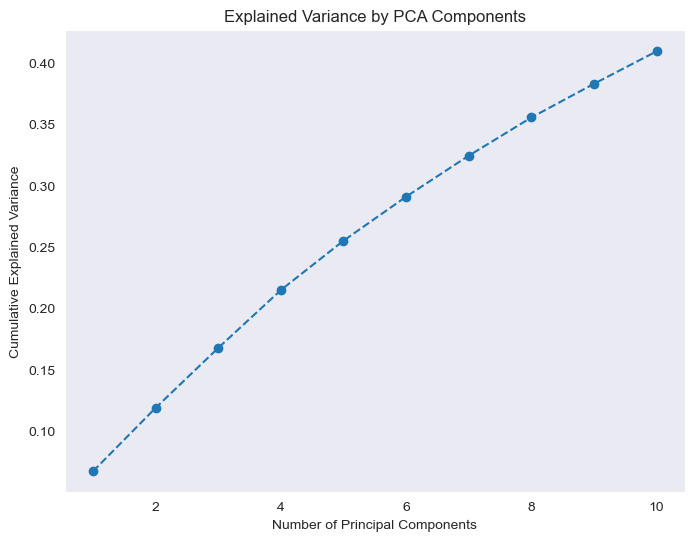

In [318]:
import matplotlib.pyplot as plt

# Plot the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid()
plt.show()

In [321]:
# Convert the PCA-transformed data to a DataFrame
df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(10)])

# Display the first few rows of the DataFrame
print(df_pca.head())

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.544146  0.104645  0.987503  0.691892  3.965126  2.460895 -0.073114   
1  1.216084 -1.053039 -0.621920  1.272184  0.043745 -0.182084  0.644914   
2  0.294170 -0.616194 -1.121547  1.844004  0.699153 -0.503789  0.414865   
3 -0.582351  1.181007 -1.304208 -0.741847 -0.398188  0.922835  2.111858   
4  1.707260  1.168903 -1.803395 -0.091454 -0.004267  0.048425  1.492330   

        PC8       PC9      PC10  
0 -0.206474 -0.626910  0.290795  
1 -1.446561 -0.427315  0.050485  
2 -1.651848 -0.629984 -1.314884  
3 -0.451852 -0.617974 -0.100176  
4 -0.173390 -0.058205 -0.129513  


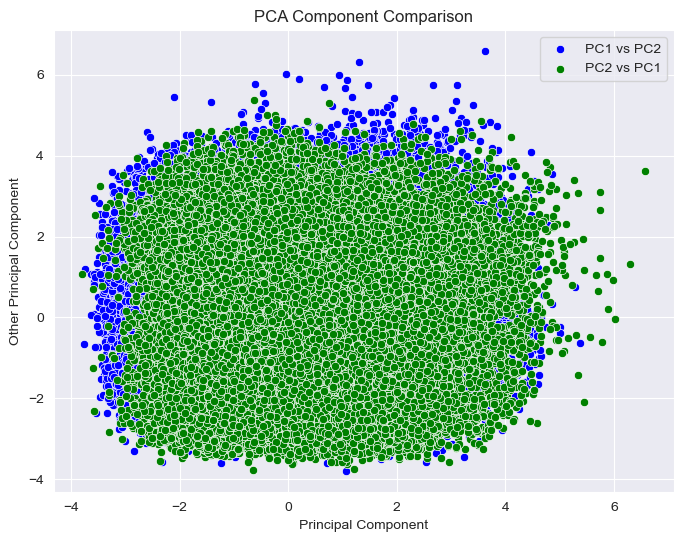

In [323]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=df_pca, color='blue', label='PC1 vs PC2')
sns.scatterplot(x='PC2', y='PC1', data=df_pca, color='green', label='PC2 vs PC1')
plt.xlabel('Principal Component')
plt.ylabel('Other Principal Component')
plt.title('PCA Component Comparison')
plt.legend()
plt.show()

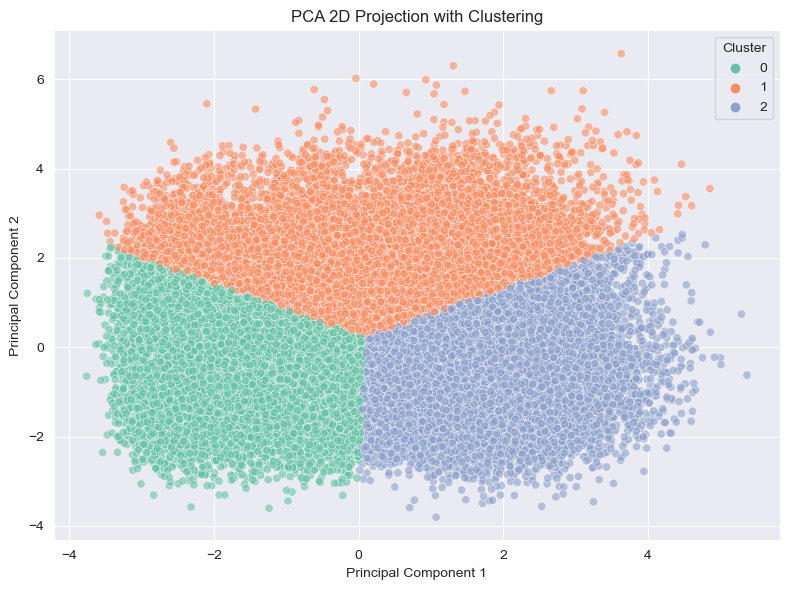

In [324]:
from sklearn.cluster import KMeans

# Create clusters
kmeans = KMeans(n_clusters=3, random_state=42)
df_pca['cluster'] = kmeans.fit_predict(df_pca[['PC1', 'PC2']])  # Cluster using only PC1 and PC2

# Now plot with cluster hue
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='PC1',
    y='PC2',
    data=df_pca,
    hue='cluster',
    palette='Set2',
    alpha=0.6
)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA 2D Projection with Clustering')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


PCA Feature Contributions (Loadings):
                                  PC1       PC2       PC3       PC4       PC5  \
time_in_hospital             0.207163  0.024791  0.055426 -0.365779 -0.204851   
num_lab_procedures           0.160015 -0.222579  0.104510 -0.240428 -0.212672   
num_procedures               0.034625  0.267270 -0.205497 -0.215802 -0.077133   
num_medications              0.290216  0.210652 -0.058691 -0.302350 -0.110591   
number_diagnoses             0.124738 -0.057402  0.133041 -0.360135 -0.024630   
number_changes               0.373617 -0.032511 -0.001808  0.092346 -0.020525   
number_meds                  0.462484  0.032850 -0.093371  0.182066  0.044456   
age                          0.002026  0.051626  0.124810 -0.301396 -0.061561   
number_inpatient_log         0.053715  0.064799  0.241851 -0.119959  0.413762   
number_emergency_log         0.066860  0.014247  0.231855 -0.032360  0.375365   
num_encounters_log           0.080945  0.096815  0.340596 -0.087989  0.

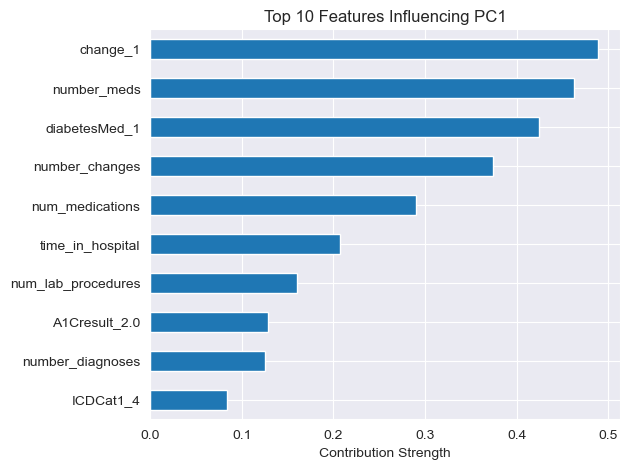

In [325]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Step 1: Fit PCA and transform the data
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# Step 2: Create a DataFrame with the PCA results
df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(10)])

# Step 3: Create a DataFrame of feature loadings (aka PCA components)
loadings = pd.DataFrame(
    pca.components_.T,  # transpose so rows = features, columns = PCs
    columns=[f'PC{i+1}' for i in range(10)],
    index=df_features.columns     # original feature names
)

print("PCA Feature Contributions (Loadings):")
print(loadings)

# Step 4: View top contributing features to PC1
top_features_pc1 = loadings['PC1'].abs().sort_values(ascending=False)
print("\nTop 10 Features Contributing to PC1:")
print(top_features_pc1.head(10))

# Step 5: Optional bar plot
top_features_pc1.head(10).plot(kind='barh', title='Top 10 Features Influencing PC1')
plt.xlabel('Contribution Strength')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [329]:
# Get the PCA loadings (feature contributions to PCs)
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=df_features.columns  # Use X.columns if X is available
)

# Sort features by their absolute contribution to PC2
top_features_pc2 = loadings['PC2'].abs().sort_values(ascending=False)

# Print top 10 features contributing to PC2
print("Top 10 Features Influencing PC2:")
print(top_features_pc2.head(10))


Top 10 Features Influencing PC2:
admission_source_id_7    0.515785
admission_source_id_9    0.339784
admission_type_id_3      0.338340
admission_type_id_5      0.301235
num_procedures           0.267270
ICDCat1_6                0.235178
num_lab_procedures       0.222579
num_medications          0.210652
max_glu_serum_2.0        0.181590
race_Caucasian           0.162324
Name: PC2, dtype: float64


In [331]:
df_pca.head(5)

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.539670  0.177765  0.913583  0.692272  3.990348  2.427712  0.137686   
1  1.209309 -1.054221 -0.611486  1.293170  0.028178 -0.258630  0.548389   
2  0.290651 -0.588368 -1.131849  1.692504  0.462451 -0.628753 -0.074396   
3 -0.580571  1.178355 -1.297263 -0.754882 -0.411067  0.672497  2.253174   
4  1.702782  1.153519 -1.802114 -0.130277 -0.056378 -0.131116  1.549892   

        PC8       PC9      PC10  
0 -0.213997 -1.189246  0.403924  
1 -1.390221 -0.329323  0.244408  
2 -1.468484 -0.321623 -0.440677  
3 -0.263298 -0.611677  0.501600  
4 -0.192818  0.037951 -0.283889

In [333]:
df_features.head()

time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
2                 2                  11               5               13   
3                 2                  44               1               16   
4                 1                  51               0                8   
5                 3                  31               6               16   
6                 4                  70               1               21   

   number_diagnoses  number_changes  number_meds  age  number_inpatient_log  \
2                 6               0            1   25              0.693147   
3                 7               1            1   35              0.000000   
4                 5               0            2   45              0.000000   
5                 9               0            1   55              0.000000   
6                 7               0            3   65              0.000000   

   number_emergency_log  num_encounters_log  race_Asian  race_Caucasian  \
2                   0.0            1.386294       False           False   
3                   0.0            0.000000       False            True   
4                   0.0            0.000000       False            True   
5                   0.0            0.000000       False            True   
6                   0.0            0.000000       False            True   

   race_Hispanic  race_Other  race_Unknown  gender_1  admission_type_id_3  \
2          False       False         False     False                False   
3          False       False         False      True                False   
4          False       False         False      True                False   
5          False       False         False      True                False   
6          False       False         False      True                 True   

   admission_type_id_4  admission_type_id_5  discharge_disposition_id_2  \
2                False                False                       False   
3                False                False                       False   
4                False                False                       False   
5                False                False                       False   
6                False                False                       False   

   discharge_disposition_id_7  discharge_disposition_id_10  \
2                       False                        False   
3                       False                        False   
4                       False                        False   
5                       False                        False   
6                       False                        False   

   discharge_disposition_id_12  discharge_disposition_id_18  \
2                        False                        False   
3                        False                        False   
4                        False                        False   
5                        False                        False   
6                        False                        False   

   discharge_disposition_id_28  admission_source_id_4  admission_source_id_7  \
2                        False                  False                   True   
3                        False                  False                   True   
4                        False                  False                   True   
5                        False                  False                  False   
6                        False                  False                  False   

   admission_source_id_8  admission_source_id_9  admission_source_id_11  \
2                  False                  False                   False   
3                  False                  False                   False   
4                  False                  False                   False   
5                  False                  False                   False   
6                  False                  False                   False   

   max_glu_serum_2.0  

In [335]:
datafinal.head(5)

time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
2                 2                  11               5               13   
3                 2                  44               1               16   
4                 1                  51               0                8   
5                 3                  31               6               16   
6                 4                  70               1               21   

   number_diagnoses readmitted  number_changes  number_meds  age  \
2                 6         No               0            1   25   
3                 7         No               1            1   35   
4                 5         No               0            2   45   
5                 9         No               0            1   55   
6                 7         No               0            3   65   

   number_inpatient_log  number_emergency_log  num_encounters_log  race_Asian  \
2              0.693147                   0.0            1.386294       False   
3              0.000000                   0.0            0.000000       False   
4              0.000000                   0.0            0.000000       False   
5              0.000000                   0.0            0.000000       False   
6              0.000000                   0.0            0.000000       False   

   race_Caucasian  race_Hispanic  race_Other  race_Unknown  gender_1  \
2           False          False       False         False     False   
3            True          False       False         False      True   
4            True          False       False         False      True   
5            True          False       False         False      True   
6            True          False       False         False      True   

   admission_type_id_3  admission_type_id_4  admission_type_id_5  \
2                False                False                False   
3                False                False                False   
4                False                False                False   
5                False                False                False   
6                 True                False                False   

   discharge_disposition_id_2  discharge_disposition_id_7  \
2                       False                       False   
3                       False                       False   
4                       False                       False   
5                       False                       False   
6                       False                       False   

   discharge_disposition_id_10  discharge_disposition_id_12  \
2                        False                        False   
3                        False                        False   
4                        False                        False   
5                        False                        False   
6                        False                        False   

   discharge_disposition_id_18  discharge_disposition_id_28  \
2                        False                        False   
3                        False                        False   
4                        False                        False   
5                        False                        False   
6                        False                        False   

   admission_source_id_4  admission_source_id_7  admission_source_id_8  \
2                  False                   True                  False   
3                  False                   True                  False   
4                  False                   True                  False   
5                  False                  False                  False   
6                  False                  False                  False   

   admission_source_id_9  admission_source_id_11  max_glu_serum_2.0  \
2                  False                   False              False   
3                  False                   False              False   
4                  False 

In [337]:
# X = PCA-transformed features
X = df_pca  # already contains PC1, PC2, ..., PC10

# y = original target variable
y = datafinal['readmitted']  # assuming this still exists and is aligned by row


In [339]:
X.head(5)

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.539670  0.177765  0.913583  0.692272  3.990348  2.427712  0.137686   
1  1.209309 -1.054221 -0.611486  1.293170  0.028178 -0.258630  0.548389   
2  0.290651 -0.588368 -1.131849  1.692504  0.462451 -0.628753 -0.074396   
3 -0.580571  1.178355 -1.297263 -0.754882 -0.411067  0.672497  2.253174   
4  1.702782  1.153519 -1.802114 -0.130277 -0.056378 -0.131116  1.549892   

        PC8       PC9      PC10  
0 -0.213997 -1.189246  0.403924  
1 -1.390221 -0.329323  0.244408  
2 -1.468484 -0.321623 -0.440677  
3 -0.263298 -0.611677  0.501600  
4 -0.192818  0.037951 -0.283889

In [341]:
# Convert categorical labels to numeric (0 = 'No', 1 = 'Yes')
y = y.map({'No': 0, 'Yes': 1})

# Now check if the conversion worked
print(y.unique())  # Should print: [0 1]

[0 1]


In [347]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from collections import Counter

# Step 1: Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.5,
    random_state=2,
    stratify=y
)

# Step 2: Cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Step 3: Class distribution check (optional, for your understanding)
print('Original Dataset: Class 0=%d, Class 1=%d' % (len(y[y==0]), len(y[y==1])))
print('Train: Class 0=%d, Class 1=%d' % (len(y_train[y_train==0]), len(y_train[y_train==1]))) 
print('Test: Class 0=%d, Class 1=%d' % (len(y_test[y_test==0]), len(y_test[y_test==1])))

print('\nRelative frequencies of the class (train):')
print(y_train.value_counts(normalize=True))

print('\nRelative frequencies of the class (test):')
print(y_test.value_counts(normalize=True))

# 🔄 Step 4: Apply SMOTE to training data ONLY
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# ✅ Optional: Check the new class distribution after SMOTE
print('\nAfter SMOTE (on training set):')
print(Counter(y_train_smote))
print(Counter(X_train_smote))

Original Dataset: Class 0=55377, Class 1=5158
Train: Class 0=27688, Class 1=2579
Test: Class 0=27689, Class 1=2579

Relative frequencies of the class (train):
readmitted
0    0.914792
1    0.085208
Name: proportion, dtype: float64

Relative frequencies of the class (test):
readmitted
0    0.914795
1    0.085205
Name: proportion, dtype: float64

After SMOTE (on training set):
Counter({0: 27688, 1: 27688})
Counter({'PC1': 1, 'PC2': 1, 'PC3': 1, 'PC4': 1, 'PC5': 1, 'PC6': 1, 'PC7': 1, 'PC8': 1, 'PC9': 1, 'PC10': 1})


In [349]:
X_train.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
43404 -1.123655 -0.722297  0.495811 -1.616792 -1.057317  0.303235 -1.873538   
37565 -2.513894  0.626922 -0.809410 -0.818254 -0.488705  0.580767  1.525521   
12919 -0.080753 -1.039092  0.696966 -1.807137 -0.401544 -1.617190 -0.825916   
59259 -3.195031  1.001745 -1.633222  0.428347  0.783430  0.075892  0.427661   
720   -1.521343  2.280501 -0.211106  0.666466 -1.820222  0.900237  2.525283   

            PC8       PC9      PC10  
43404  0.490682  0.904802 -0.507000  
37565 -0.072243 -0.469343  0.081249  
12919  0.734750  0.038406 -1.363485  
59259  1.284910 -0.882125  0.172068  
720   -0.107686  0.146125  0.246438

In [351]:
X_train_smote.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -1.123655 -0.722297  0.495811 -1.616792 -1.057317  0.303235 -1.873538   
1 -2.513894  0.626922 -0.809410 -0.818254 -0.488705  0.580767  1.525521   
2 -0.080753 -1.039092  0.696966 -1.807137 -0.401544 -1.617190 -0.825916   
3 -3.195031  1.001745 -1.633222  0.428347  0.783430  0.075892  0.427661   
4 -1.521343  2.280501 -0.211106  0.666466 -1.820222  0.900237  2.525283   

        PC8       PC9      PC10  
0  0.490682  0.904802 -0.507000  
1 -0.072243 -0.469343  0.081249  
2  0.734750  0.038406 -1.363485  
3  1.284910 -0.882125  0.172068  
4 -0.107686  0.146125  0.246438

In [183]:
print(X_train.shape)       # Shape before applying SMOTE
print(X_train_smote.shape) # Shape after applying SMOTE

(30267, 10)
(55376, 10)


In [353]:
print(Counter(X_train_smote))

Counter({'PC1': 1, 'PC2': 1, 'PC3': 1, 'PC4': 1, 'PC5': 1, 'PC6': 1, 'PC7': 1, 'PC8': 1, 'PC9': 1, 'PC10': 1})


# Logistic Regression

In [367]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Step 5: Train model on the SMOTE-balanced data
model = LogisticRegression(max_iter=1000)
model.fit(X_train_smote, y_train_smote)

LogisticRegression(max_iter=1000)

In [369]:
# Step 6: Make predictions on the test set
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:, 1]  # for ROC-AUC

# Evaluate the performance
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('AUC Score:', roc_auc_score(y_test, y_probs))

[[16278 11411]
 [ 1138  1441]]
              precision    recall  f1-score   support

           0       0.93      0.59      0.72     27689
           1       0.11      0.56      0.19      2579

    accuracy                           0.59     30268
   macro avg       0.52      0.57      0.45     30268
weighted avg       0.86      0.59      0.68     30268

AUC Score: 0.5985514815859436


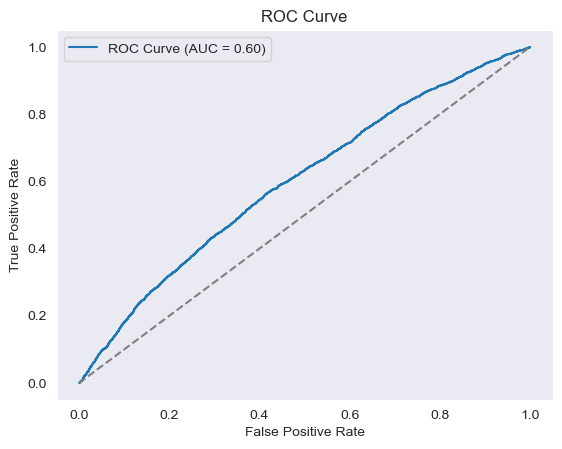

In [371]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_score(y_test, y_probs)))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()


## Logistic Regression hyperparameter tuning by using Gridsearch

In [373]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


In [375]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],         # Inverse of regularization (smaller = stronger penalty)
    'solver': ['liblinear', 'lbfgs'],  # solvers: good for small datasets
    'penalty': ['l2'],                # 'l2' regularization (default)
}

In [377]:
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000)

grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='f1',           # Or use 'recall' or 'roc_auc' based on your goal
    cv=5,                   # 5-fold cross-validation
    n_jobs=-1,              # Use all cores
    verbose=1
)
grid_search.fit(X_train_smote, y_train_smote)
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score from CV:", grid_search.best_score_)
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
y_probs = best_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_probs))


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best F1 Score from CV: 0.572859241900167
              precision    recall  f1-score   support

           0       0.93      0.59      0.72     27689
           1       0.11      0.56      0.19      2579

    accuracy                           0.59     30268
   macro avg       0.52      0.57      0.45     30268
weighted avg       0.86      0.59      0.68     30268

AUC Score: 0.5985632026447414


# Random Forest Classifier

🧾 Confusion Matrix:
[[25555  2134]
 [ 2303   276]]


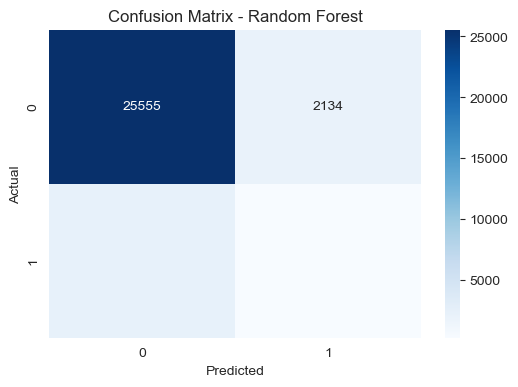

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     27689
           1       0.11      0.11      0.11      2579

    accuracy                           0.85     30268
   macro avg       0.52      0.51      0.52     30268
weighted avg       0.85      0.85      0.85     30268

🎯 AUC Score: 0.5718


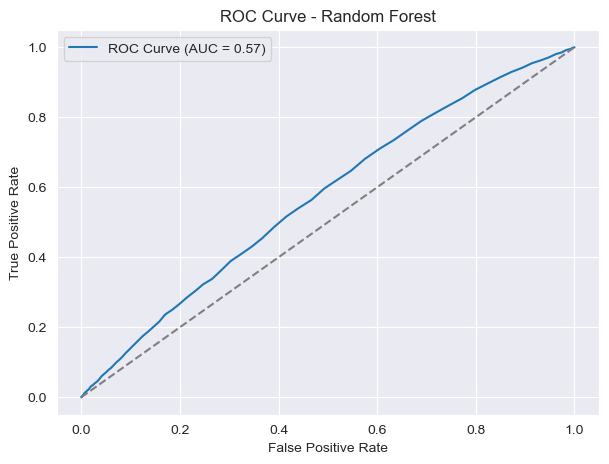

In [381]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Train the Random Forest model
rf = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=100,
    max_depth=None,
    random_state=42
)
rf.fit(X_train_smote, y_train_smote)

# 2. Predict on test set
y_pred_rf = rf.predict(X_test)
y_probs_rf = rf.predict_proba(X_test)[:, 1]

# 3. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
print("🧾 Confusion Matrix:")
print(cm)

# Optional: Visualize it
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 4. Classification Report
print("📋 Classification Report:")
print(classification_report(y_test, y_pred_rf))

# 5. AUC Score
auc_score_rf = roc_auc_score(y_test, y_probs_rf)
print(f"🎯 AUC Score: {auc_score_rf:.4f}")

# 6. ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf)

plt.figure(figsize=(7, 5))
plt.plot(fpr_rf, tpr_rf, label=f"ROC Curve (AUC = {auc_score_rf:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid(True)
plt.show()


In [383]:
pip install scikit-optimize

   ---------------------------------------- 0.0/107.8 kB ? eta -:--:--
   ----------- ---------------------------- 30.7/107.8 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 107.8/107.8 kB 2.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## Random Forest Hyperparameter tuning by using Bayesian Optimization 

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

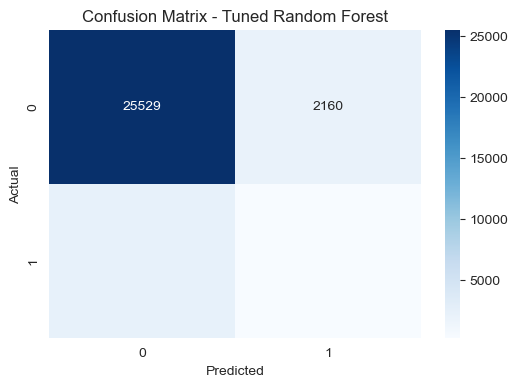

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     27689
           1       0.12      0.11      0.12      2579

    accuracy                           0.85     30268
   macro avg       0.52      0.52      0.52     30268
weighted avg       0.85      0.85      0.85     30268

🎯 AUC Score: 0.5735


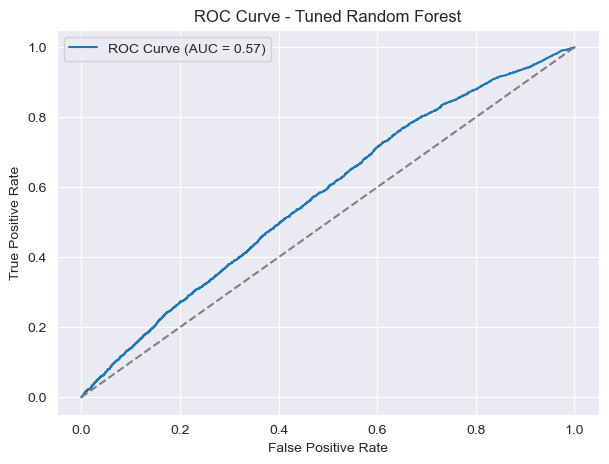

In [385]:
from skopt import BayesSearchCV
from skopt.space import Integer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define the hyperparameter search space
search_space = {
    'n_estimators': Integer(100, 300),
    'max_depth': Integer(5, 30),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 5)
}

# 2. Setup BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42),
    search_spaces=search_space,
    n_iter=30,                      # Try 30 combinations
    scoring='f1',                   # Optimize for F1-score
    cv=3,                           # 3-fold cross-validation
    n_jobs=-1,                      # Use all CPUs
    verbose=1,
    random_state=42
)

# 3. Fit the model
bayes_search.fit(X_train_smote, y_train_smote)

# 4. Best Parameters
print("✅ Best Parameters Found:")
print(bayes_search.best_params_)

# 5. Best Estimator
best_model = bayes_search.best_estimator_

# 6. Predict on Test Set
y_pred = best_model.predict(X_test)
y_probs = best_model.predict_proba(X_test)[:, 1]

# 7. Evaluation Metrics

## Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("🧾 Confusion Matrix:")
print(cm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Tuned Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Classification Report
print("📋 Classification Report:")
print(classification_report(y_test, y_pred))

## AUC Score
auc_score = roc_auc_score(y_test, y_probs)
print(f"🎯 AUC Score: {auc_score:.4f}")

## ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Tuned Random Forest")
plt.legend()
plt.grid(True)
plt.show()


# XGBClassifier 

🧾 Confusion Matrix:
[[ 8597 19092]
 [  687  1892]]


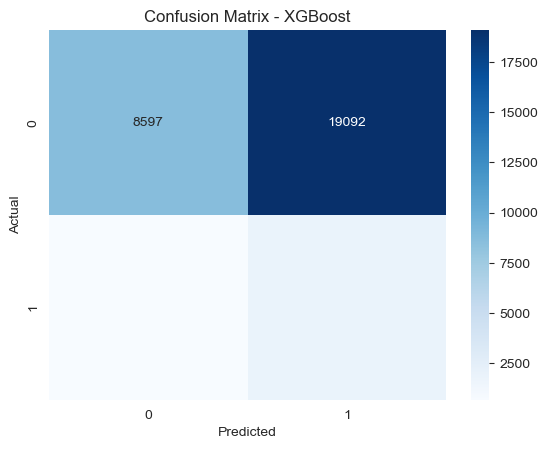

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.31      0.47     27689
           1       0.09      0.73      0.16      2579

    accuracy                           0.35     30268
   macro avg       0.51      0.52      0.31     30268
weighted avg       0.85      0.35      0.44     30268

🎯 AUC Score: 0.5441


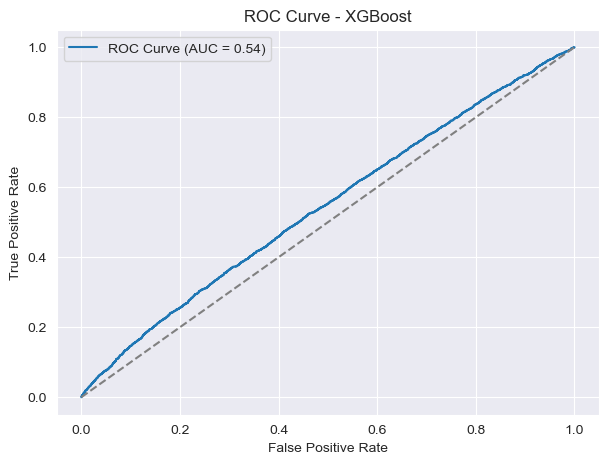

In [387]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Train the model
xgb = XGBClassifier(
    scale_pos_weight=10,  # helps handle class imbalance
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_train_smote, y_train_smote)

# 2. Predict
y_pred = xgb.predict(X_test)
y_probs = xgb.predict_proba(X_test)[:, 1]

# 3. Evaluation

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("🧾 Confusion Matrix:")
print(cm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("📋 Classification Report:")
print(classification_report(y_test, y_pred))

# AUC Score
auc_score = roc_auc_score(y_test, y_probs)
print(f"🎯 AUC Score: {auc_score:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.grid(True)
plt.show()

# Decision Tree Classifier

🧾 Confusion Matrix:
[[21591  6098]
 [ 1929   650]]


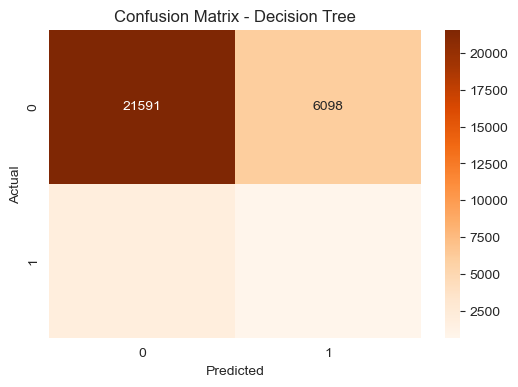

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.78      0.84     27689
           1       0.10      0.25      0.14      2579

    accuracy                           0.73     30268
   macro avg       0.51      0.52      0.49     30268
weighted avg       0.85      0.73      0.78     30268

🎯 AUC Score: 0.5159


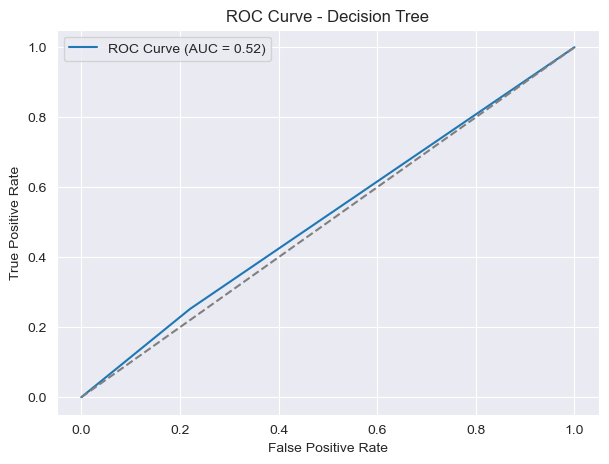

In [389]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Initialize the Decision Tree
dt = DecisionTreeClassifier(
    class_weight='balanced',  # Handle imbalance
    max_depth=None,           # Let it grow fully (you can tune this later)
    random_state=42
)

# 2. Train the model on the SMOTE-balanced training data
dt.fit(X_train_smote, y_train_smote)

# 3. Make predictions on the original test set
y_pred_dt = dt.predict(X_test)
y_probs_dt = dt.predict_proba(X_test)[:, 1]

# 4. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_dt)
print("🧾 Confusion Matrix:")
print(cm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 5. Classification Report
print("📋 Classification Report:")
print(classification_report(y_test, y_pred_dt))

# 6. AUC Score
auc_score = roc_auc_score(y_test, y_probs_dt)
print(f"🎯 AUC Score: {auc_score:.4f}")

# 7. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs_dt)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree")
plt.legend()
plt.grid(True)
plt.show()


SVM	Good for clean, small datasets	Struggles with large or imbalanced data

# Adaboost Classifier

🧾 Confusion Matrix:
[[15701 11988]
 [ 1139  1440]]


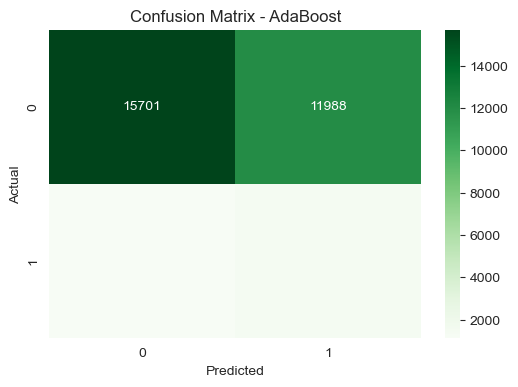

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.57      0.71     27689
           1       0.11      0.56      0.18      2579

    accuracy                           0.57     30268
   macro avg       0.52      0.56      0.44     30268
weighted avg       0.86      0.57      0.66     30268

🎯 AUC Score: 0.5838


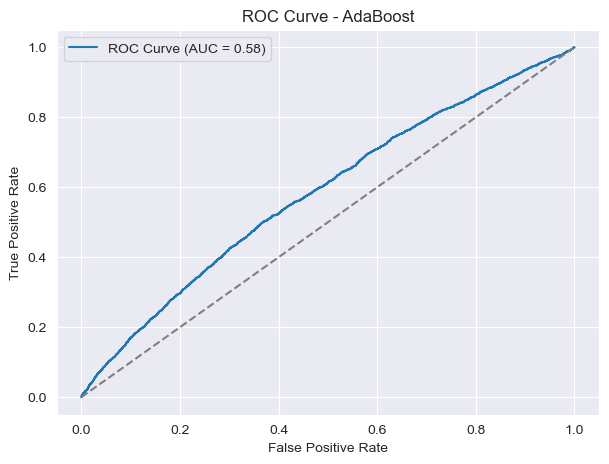

In [407]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Initialize AdaBoost (with decision trees as base estimators)
ada = AdaBoostClassifier(
    n_estimators=100,         # number of boosting rounds
    learning_rate=1.0,        # step size (you can tune this later)
    random_state=42
)

# 2. Train on SMOTE-balanced training set
ada.fit(X_train_smote, y_train_smote)

# 3. Predict on test set
y_pred_ada = ada.predict(X_test)
y_probs_ada = ada.predict_proba(X_test)[:, 1]

# 4. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_ada)
print("🧾 Confusion Matrix:")
print(cm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - AdaBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 5. Classification Report
print("📋 Classification Report:")
print(classification_report(y_test, y_pred_ada))

# 6. AUC Score
auc_score = roc_auc_score(y_test, y_probs_ada)
print(f"🎯 AUC Score: {auc_score:.4f}")

# 7. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs_ada)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - AdaBoost")
plt.legend()
plt.grid(True)
plt.show()


# Gradient Boosting Classifier

🧾 Confusion Matrix:
[[16515 11174]
 [ 1195  1384]]


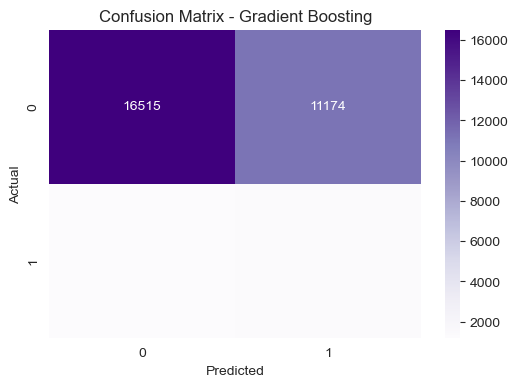

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.60      0.73     27689
           1       0.11      0.54      0.18      2579

    accuracy                           0.59     30268
   macro avg       0.52      0.57      0.46     30268
weighted avg       0.86      0.59      0.68     30268

🎯 AUC Score: 0.5919


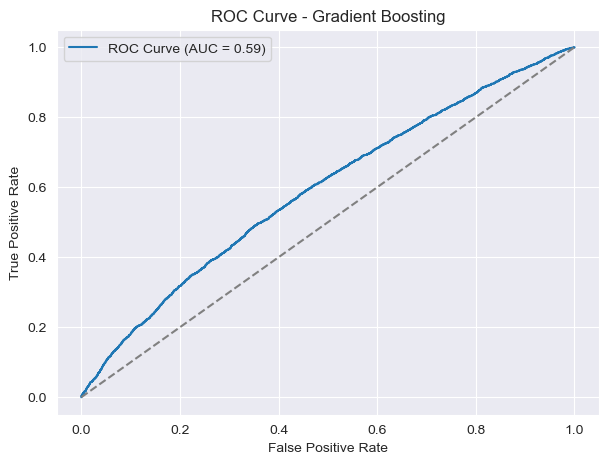

In [409]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Initialize the Gradient Boosting model
gb = GradientBoostingClassifier(
    n_estimators=100,         # number of trees
    learning_rate=0.1,        # shrinkage (learning rate)
    max_depth=3,              # depth of each tree
    random_state=42
)

# 2. Train on SMOTE-balanced data
gb.fit(X_train_smote, y_train_smote)

# 3. Predict on original test set
y_pred_gb = gb.predict(X_test)
y_probs_gb = gb.predict_proba(X_test)[:, 1]

# 4. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_gb)
print("🧾 Confusion Matrix:")
print(cm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix - Gradient Boosting")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 5. Classification Report
print("📋 Classification Report:")
print(classification_report(y_test, y_pred_gb))

# 6. AUC Score
auc_score = roc_auc_score(y_test, y_probs_gb)
print(f"🎯 AUC Score: {auc_score:.4f}")

# 7. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs_gb)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Gradient Boosting")
plt.legend()
plt.grid(True)
plt.show()


In [413]:
pip install shap

   ---------------------------------------- 0.0/489.8 kB ? eta -:--:--
   --- ----------------------------------- 41.0/489.8 kB 991.0 kB/s eta 0:00:01
   -------------------------------------- - 471.0/489.8 kB 5.9 MB/s eta 0:00:01
   ---------------------------------------- 489.8/489.8 kB 5.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


📋 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.60      0.73     27689
           1       0.11      0.54      0.18      2579

    accuracy                           0.59     30268
   macro avg       0.52      0.57      0.46     30268
weighted avg       0.86      0.59      0.68     30268

🎯 AUC Score: 0.5919


 99%|===================| 30054/30268 [00:34<00:00]        

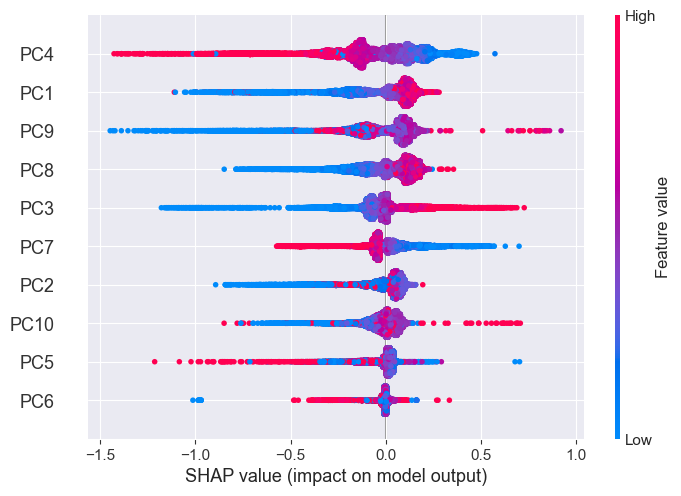

In [415]:
import shap
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Train Gradient Boosting model (if not done already)
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb.fit(X_train_smote, y_train_smote)

# 2. Evaluate
y_pred = gb.predict(X_test)
y_probs = gb.predict_proba(X_test)[:, 1]

print("📋 Classification Report:")
print(classification_report(y_test, y_pred))

auc_score = roc_auc_score(y_test, y_probs)
print(f"🎯 AUC Score: {auc_score:.4f}")

# 3. SHAP Explanation
explainer = shap.Explainer(gb, X_train_smote)
shap_values = explainer(X_test)

# 4. Global Feature Importance Plot
shap.plots.beeswarm(shap_values, max_display=15)


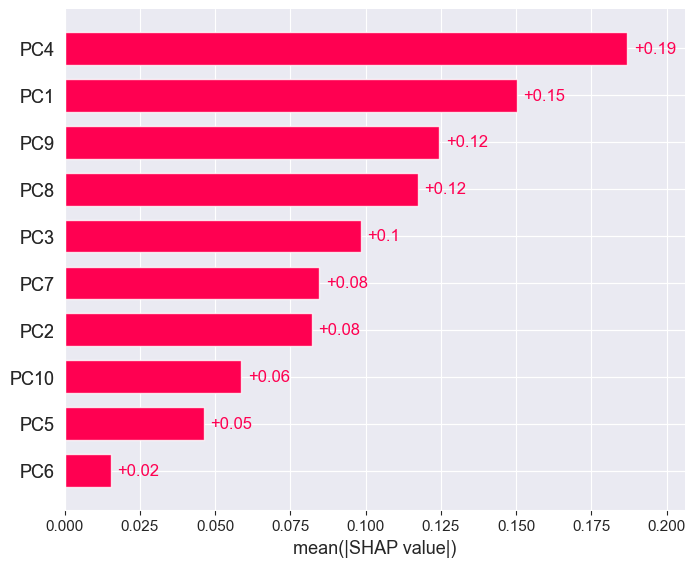

In [417]:
shap.plots.bar(shap_values, max_display=15)

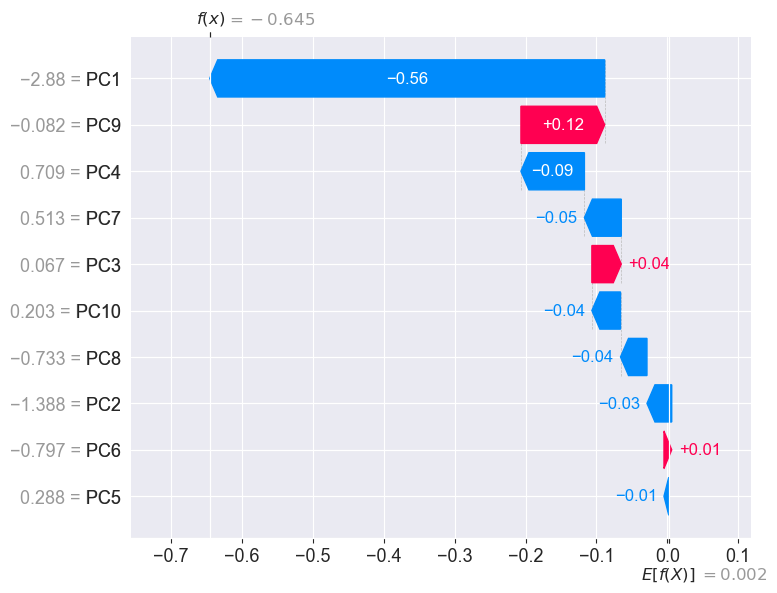

In [421]:
shap.plots.waterfall(shap_values[0])

[LightGBM] [Info] Number of positive: 27688, number of negative: 27688
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 55376, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

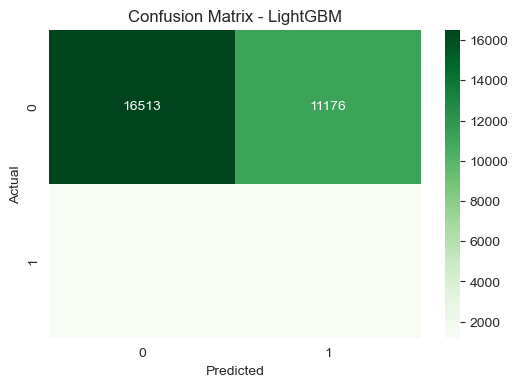

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.60      0.73     27689
           1       0.11      0.53      0.18      2579

    accuracy                           0.59     30268
   macro avg       0.52      0.57      0.45     30268
weighted avg       0.86      0.59      0.68     30268

🎯 AUC Score: 0.5931


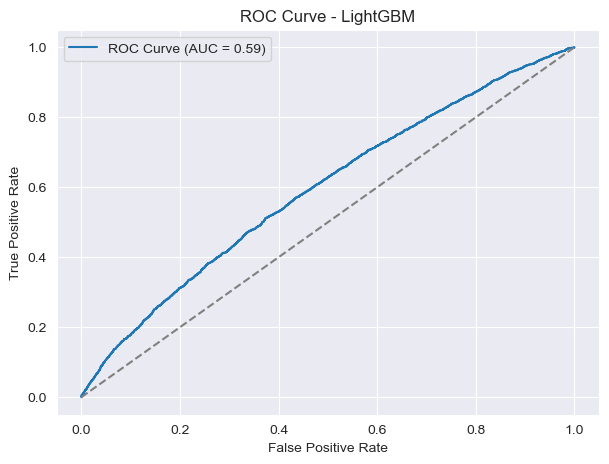

In [423]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Initialize the LightGBM model
lgbm = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    scale_pos_weight=len(y_train_smote) / sum(y_train_smote) - 1  # for handling imbalance
)

# 2. Train on SMOTE-balanced data
lgbm.fit(X_train_smote, y_train_smote)

# 3. Predict on original test set
y_pred_lgbm = lgbm.predict(X_test)
y_probs_lgbm = lgbm.predict_proba(X_test)[:, 1]

# 4. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lgbm)
print("🧾 Confusion Matrix:")
print(cm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - LightGBM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 5. Classification Report
print("📋 Classification Report:")
print(classification_report(y_test, y_pred_lgbm))

# 6. AUC Score
auc_score = roc_auc_score(y_test, y_probs_lgbm)
print(f"🎯 AUC Score: {auc_score:.4f}")

# 7. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs_lgbm)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LightGBM")
plt.legend()
plt.grid(True)
plt.show()
